In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib.colors as mcolors
import anndata as ad
import seaborn as sns
from scipy.sparse import issparse
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri as np2ri

In [10]:
from typing import Optional

import numpy as np
from anndata import AnnData
from scipy.sparse import issparse

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri as np2ri


def saver(
    adata: AnnData,
    random_seed: int = 613,
    layer: Optional[str] = None,
    normalize: bool = False,
    ncores: int = 1,
    ret_se: bool = False,
    copy: bool = False,
) -> Optional[AnnData]:
    """
    preform SAVER imputation on the given AnnData object.
    :param adata: AnnData object
    :param random_seed: random seed
    :param normalize: whether to normalize the data
    :param ncores: number of cores to use, default is 1
    :param ret_se: whether to return the standard error,
    if True, the standard error is stored in adata.layers["saver_se"]
    :paran layer: layer to use for imputation, default is None (adata.X)
    :param copy: copy AnnData object
    :return: AnnData object if copy is True, otherwise None.
    SAVER result is stored in adata.layers[layer] or adata.X
    """
    adata = adata.copy() if copy else adata
    X = adata.layers[layer] if layer is not None else adata.X
    adata.uns["saver"] = {
        "params": {
            "random_seed": random_seed,
            "normalize": normalize,
            "ret_se": ret_se,
            "layer": layer,
        }
    }
    saver_ = importr("SAVER")
    ro.r(f"set.seed({random_seed})")
    result = (
        saver_.saver(
            np2ri.numpy2rpy(
                X.toarray().T
                if issparse(X)
                else np.transpose(X)
            ),
            ncores=ncores,
        )
        if normalize
        else saver_.saver(
            np2ri.numpy2rpy(
                X.toarray().T
                if issparse(X)
                else np.transpose(X)
            ),
            size_factor=1,
            ncores=ncores,
        )
    )
    if layer is not None:
        adata.layers[layer] = np.array(result[0]).T
    else:
        adata.X = np.array(result[0]).T
    if ret_se:
        adata.layers["saver_se"] = np.array(result[1]).T
    return adata if copy else None

In [11]:
# CLL-map tables - 
# import into your code as module with "import config_cllmap_tables"
# import config_cllmap_tables
# and then save the tables as variables, for example
# master_table = config_cllmap_tables.master_table

path = "/private/resources/"

# expression data
tpms_603samps_deseqLog10_batchcorr = pd.read_csv(path + "cll_tables/cllmap_rnaseq_tpms_603samps_deseqLog10_batchcorr.tsv", sep="\t")
cllmap_rnaseq_tpms_full = pd.read_csv(path + "cll_tables/cllmap_rnaseq_tpms_full.tsv", sep="\t")


In [12]:
cllmap_rnaseq_tpms_full.shape

(57242, 717)

In [13]:
df = cllmap_rnaseq_tpms_full


# The first two columns are used for `var`
var = df.iloc[:, :2].set_index('Description')

# The remaining columns are used for `obs`
obs = pd.DataFrame(index=df.columns[2:])

# The data matrix is the remaining part of the DataFrame, transposed
X = df.iloc[:, 2:].values.T

# Create the AnnData object with the data matrix, `obs`, and `var`
adata = sc.AnnData(X=X, obs=obs, var=var)

/data01/home/ls/sarahl/miniforge3/envs/proj/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
adata

AnnData object with n_obs × n_vars = 715 × 57242
    var: 'Name'

In [15]:
descriptions_to_keep = [
'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
'ZNF471', 'KCNH2', 'COBLL1', 'SEPT10', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2']
print(len(descriptions_to_keep))

# Find duplicates
duplicates = [item for item in set(descriptions_to_keep) if descriptions_to_keep.count(item) > 1]

# Print duplicates
print("Duplicates:", duplicates)

# Filter the var DataFrame to retain only the rows with the desired descriptions
filtered_var = adata.var[adata.var.index.isin(descriptions_to_keep)]

# Subset the AnnData object using the filtered var DataFrame
adata_filtered = adata[:, adata.var.index.isin(descriptions_to_keep)]

77
Duplicates: []


In [16]:
master_table = pd.read_csv(path + "cll_tables/cllmap_master_table.20220622.tsv", sep="\t")

In [17]:
ec_table = master_table[["participant_id", "ec_name"]]

In [18]:
ec_table

,participant_id,ec_name
0,CRC-0001,EC-u1
1,CRC-0002,EC-u1
2,CRC-0003,EC-u2
3,CRC-0004,EC-m4
4,CRC-0005,EC-u2
...,...,...
1171,MBL5,NaN
1172,MBL6,NaN
1173,MBL7,NaN
1174,MBL8,NaN


In [19]:
ec_table = ec_table[ec_table['participant_id'].isin(adata_filtered.obs.index)]

In [20]:
ec_table

,participant_id,ec_name
0,CRC-0001,EC-u1
1,CRC-0002,EC-u1
2,CRC-0003,EC-u2
3,CRC-0004,EC-m4
4,CRC-0005,EC-u2
...,...,...
1148,SCLL-0501,NaN
1149,SCLL-0502,EC-m4
1150,SCLL-0503,EC-m1
1151,SCLL-0504,EC-u1


In [21]:
filtered_ec_table = ec_table[ec_table['participant_id'].isin(adata_filtered.obs.index)]
filtered_ec_table = filtered_ec_table.dropna(subset=['ec_name'])
adata_filtered = adata_filtered[filtered_ec_table['participant_id'].values].copy()

print(filtered_ec_table)

# Define a function to split the AnnData object based on EC type
def split_anndata_by_ec(adata, ec_table):
    ec_types = ec_table['ec_name'].dropna().unique()  # Get unique EC types
    adata_dict = {}  # Dictionary to store the split AnnData objects

    for ec_type in ec_types:
        samples = ec_table[ec_table['ec_name'] == ec_type]['participant_id']
        adata_subset = adata[samples, :].copy()  # Subset AnnData based on sampleIDs
        adata_dict[ec_type] = adata_subset

    return adata_dict

# Split the filtered AnnData object
adata_dict = split_anndata_by_ec(adata_filtered, filtered_ec_table)

# Verify the split AnnData objects
for ec_type, adata_subset in adata_dict.items():
    print(f"EC Type: {ec_type}, Shape: {adata_subset.shape}")

     participant_id ec_name
0          CRC-0001   EC-u1
1          CRC-0002   EC-u1
2          CRC-0003   EC-u2
3          CRC-0004   EC-m4
4          CRC-0005   EC-u2
...             ...     ...
1146      SCLL-0499   EC-m1
1149      SCLL-0502   EC-m4
1150      SCLL-0503   EC-m1
1151      SCLL-0504   EC-u1
1152      SCLL-0505   EC-u2

[603 rows x 2 columns]
EC Type: EC-u1, Shape: (188, 77)
EC Type: EC-u2, Shape: (64, 77)
EC Type: EC-m4, Shape: (113, 77)
EC Type: EC-m3, Shape: (54, 77)
EC Type: EC-i, Shape: (62, 77)
EC Type: EC-o, Shape: (21, 77)
EC Type: EC-m1, Shape: (53, 77)
EC Type: EC-m2, Shape: (48, 77)


In [22]:
import numpy as np
adata_avg_dict = {}

for ec_type, adata_subset in adata_dict.items():
    avg_expression = np.mean(adata_subset.X, axis=0)  # Calculate the average expression for each gene
    avg_expression = avg_expression.reshape(1, -1)  # Reshape to keep 2D structure
    adata_avg = sc.AnnData(X=avg_expression, var=adata_subset.var.copy())  # Create a new AnnData object
    adata_avg.obs['ec_name'] = [ec_type]  # Add EC type to obs
    adata_avg_dict[ec_type] = adata_avg

# Combine the individual AnnData objects into one
adata_combined = sc.concat(adata_avg_dict.values(), join='outer', merge='same')

# Verify the combined AnnData object
print(adata_combined.X)

[[3.11151636e+01 3.66196496e+00 1.04393787e+01 2.88928518e+01
  3.34417850e+01 9.12423094e+01 1.95337344e+02 9.12811088e+00
  1.56838960e+01 1.45214278e+01 3.00744371e+02 1.00291570e+01
  1.18154714e+01 7.69288689e+00 3.51819112e+01 1.75431158e+01
  1.07794368e+01 3.68364009e+00 2.35119750e+02 2.19250454e+00
  4.10909959e+00 8.68901766e+01 8.93598797e+01 1.11389743e+00
  4.20815804e+00 4.58641719e+00 5.84443654e-01 1.00178229e+02
  3.85314859e+00 1.08282472e+01 5.93119022e+01 7.92914891e+00
  2.20370245e+00 1.14078678e+01 1.14057191e+01 1.88807367e+01
  2.14875302e+00 4.57125836e+00 3.25256093e+00 7.48936957e+00
  3.16344175e+00 8.15952739e+01 6.97611518e+00 1.57643197e+01
  5.31560964e+01 6.65706223e+01 2.07982131e+01 2.93889919e+01
  2.25369731e+01 3.40072388e+01 6.71473670e+00 1.40826996e+00
  8.88559633e-01 2.10408674e+01 8.26819284e+01 6.44826700e+00
  5.24580488e+01 1.06989658e+01 1.56154166e+01 1.45835461e+01
  6.08993755e+00 1.10753777e+01 3.28251028e+01 1.90361202e+01
  1.2033

/data01/home/ls/sarahl/miniforge3/envs/proj/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
if 'GRIK3' in df.index:
    il13ra1_values = df.loc['GRIK3']
    print(f"Expression values for GRIK3:\n{il13ra1_values}")
else:
    print("IL13RA1 not found in the dataset.")

IL13RA1 not found in the dataset.


In [23]:
def normalize_to_one(adata):
    # Normalize each row to sum to 1
    normalized_X = adata.X / adata.X.sum(axis=1, keepdims=True)
    return sc.AnnData(X=normalized_X, obs=adata.obs.copy(), var=adata.var.copy())

# Dictionary to store normalized AnnData objects
adata_normalized_dict = {}

# Normalize each EC type separately
for ec_type, adata_subset in adata_avg_dict.items():
    adata_normalized = normalize_to_one(adata_subset)
    adata_normalized_dict[ec_type] = adata_normalized

# Combine the normalized AnnData objects into one
adata_combined_normalized = sc.concat(adata_normalized_dict.values(), join='outer', merge='same')

# Verify the combined normalized AnnData object
print(adata_combined_normalized.obs)

def validate_normalization(adata):
    row_sums = adata.X.sum(axis=1)
    return np.allclose(row_sums, 1)

for ec_type, adata_normalized in adata_normalized_dict.items():
    is_valid = validate_normalization(adata_normalized)
    print(f"Normalization validation for {ec_type}: {is_valid}")


  ec_name
0   EC-u1
0   EC-u2
0   EC-m4
0   EC-m3
0    EC-i
0    EC-o
0   EC-m1
0   EC-m2
Normalization validation for EC-u1: True
Normalization validation for EC-u2: True
Normalization validation for EC-m4: True
Normalization validation for EC-m3: True
Normalization validation for EC-i: True
Normalization validation for EC-o: True
Normalization validation for EC-m1: True
Normalization validation for EC-m2: True


/data01/home/ls/sarahl/miniforge3/envs/proj/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [24]:
from scipy.stats import spearmanr

check = sc.read_h5ad("raw_data/sc_cll_3ca.h5ad")

descriptions_to_keep = [
'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
'ZNF471', 'KCNH2', 'COBLL1', 'SEPT10', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2']

# Calculate the length of the array
array_length = len(descriptions_to_keep)

# Print the length of the array
print(f"The length of the array is: {array_length}")
# Filter the var DataFrame to retain only the rows with the desired descriptions
filtered_var = check.var[check.var.index.isin(descriptions_to_keep)]

# Subset the AnnData object using the filtered var DataFrame
adata_filtered = adata[:, adata.var.index.isin(descriptions_to_keep)]

# Step 1: Subset the AnnData object to include only the sample 'CRC-0004'
ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])

print(adata_filtered.shape)
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    print(sample_expression.shape)  # C

The length of the array is: 77
(715, 77)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)

In [25]:
check = sc.read_h5ad("raw_data/sc_cll_3ca.h5ad")
check.X

<720x55764 sparse matrix of type '<class 'numpy.float32'>'
	with 3271112 stored elements in Compressed Sparse Column format>

In [26]:
check = sc.read_h5ad("raw_data/sc_cll_3ca.h5ad")
check.shape

(720, 55764)

In [27]:
ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])
ec_profiles.shape

(77, 8)

In [28]:
import scanpy as sc

# Read the h5ad file
check = sc.read_h5ad("raw_data/sc_cll_3ca.h5ad")

# List of descriptions to keep
descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]

# Identify duplicates in descriptions_to_keep
duplicates = [gene for gene in set(descriptions_to_keep) if descriptions_to_keep.count(gene) > 1]

# Identify missing genes from descriptions_to_keep that are not in check.var.index
missing_genes = [gene for gene in descriptions_to_keep if gene not in check.var.index]

# Output the results
print(f"Duplicates in descriptions_to_keep: {duplicates}")
print(f"Missing genes: {missing_genes}")


filtered_var = check[:, check.var.index.isin(descriptions_to_keep)]
filtered_var.shape


Duplicates in descriptions_to_keep: []
Missing genes: []


(720, 77)

In [31]:
#Run SAVER on the filtered AnnData object
adata_filtered = sc.read_h5ad("raw_data/sc_cll_3ca.h5ad")
adata_filtered.layers['counts'] = adata_filtered.X.copy()
saver(
    adata_filtered, 
    random_seed=613,
    normalize=True, 
    ncores=64, 
    ret_se=True, 
    copy=False
)
sc.pp.normalize_total(adata_filtered)
sc.pp.log1p(adata_filtered)

R[write to console]: 55764 genes, 720 cells



starting worker pid=975334 on localhost:11046 at 20:45:27.621
starting worker pid=975336 on localhost:11046 at 20:45:27.621
starting worker pid=975335 on localhost:11046 at 20:45:27.621
starting worker pid=975392 on localhost:11046 at 20:45:27.622
starting worker pid=975434 on localhost:11046 at 20:45:27.622
starting worker pid=975341 on localhost:11046 at 20:45:27.622
starting worker pid=975342 on localhost:11046 at 20:45:27.622
starting worker pid=975368 on localhost:11046 at 20:45:27.622
starting worker pid=975404 on localhost:11046 at 20:45:27.622
starting worker pid=975337 on localhost:11046 at 20:45:27.626
starting worker pid=975429 on localhost:11046 at 20:45:27.627
starting worker pid=975340 on localhost:11046 at 20:45:27.658
starting worker pid=975343 on localhost:11046 at 20:45:27.659
starting worker pid=975393 on localhost:11046 at 20:45:27.659
starting worker pid=975358 on localhost:11046 at 20:45:27.675
starting worker pid=975352 on localhost:11046 at 20:45:27.676
starting

R[write to console]: Running SAVER with 64 worker(s)

R[write to console]: Calculating predictions for 45582 genes using 21401 genes and 720 cells...

R[write to console]: Start time: 2024-08-24 20:45:29

R[write to console]: Estimating finish time...

Loading required package: SAVER
loaded SAVER and set parent environment
Loading required package: SAVER
loaded SAVER and set parent environment
Loading required package: SAVER
loaded SAVER and set parent environment
Loading required package: SAVER
loaded SAVER and set parent environment
Loading required package: SAVER
loaded SAVER and set parent environment
Loading required package: SAVER
loaded SAVER and set parent environment
Loading required package: SAVER
loaded SAVER and set parent environment
Loading required package: SAVER
loaded SAVER and set parent environment
Loading required package: SAVER
loaded SAVER and set parent environment
Loading required package: SAVER
loaded SAVER and set parent environment
Loading required package: S

In [32]:
adata_filtered

AnnData object with n_obs × n_vars = 720 × 55764
    obs: 'sample', 'patient', 'sample_status', 'complexity'
    uns: 'saver', 'log1p'
    layers: 'counts', 'saver_se'

In [33]:
adata_filtered.write_h5ad("raw_data/SAVER_sc_cll_3ca.h5ad")

In [34]:
adata_new = sc.read_h5ad("raw_data/SAVER_sc_cll_3ca.h5ad")

In [35]:
adata_new

AnnData object with n_obs × n_vars = 720 × 55764
    obs: 'sample', 'patient', 'sample_status', 'complexity'
    uns: 'log1p', 'saver'
    layers: 'counts', 'saver_se'

In [36]:
print(adata_new.obs)

                                     sample patient  sample_status  complexity
cell_name                                                                     
CLL03_T0_cDNA_A10_S202  CLL03_pre_treatment   CLL03  pre_treatment        4941
CLL03_T0_cDNA_A11_S203  CLL03_pre_treatment   CLL03  pre_treatment        6307
CLL03_T0_cDNA_A12_S204  CLL03_pre_treatment   CLL03  pre_treatment        2939
CLL03_T0_cDNA_A1_S193   CLL03_pre_treatment   CLL03  pre_treatment        7023
CLL03_T0_cDNA_A2_S194   CLL03_pre_treatment   CLL03  pre_treatment        6222
...                                     ...     ...            ...         ...
CLL12_cDNA_H5_S185      CLL12_pre_treatment   CLL12  pre_treatment        1961
CLL12_cDNA_H6_S186      CLL12_pre_treatment   CLL12  pre_treatment        5563
CLL12_cDNA_H7_S187      CLL12_pre_treatment   CLL12  pre_treatment        5844
CLL12_cDNA_H9_S189      CLL12_pre_treatment   CLL12  pre_treatment        3733
CLL12_cDNA_H8_S188      CLL12_pre_treatment   CLL12 

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.stats import spearmanr

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Define the desired order for the columns
desired_order = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]

# Subset the data to keep only the relevant gene descriptions
descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]

adata_new = adata_new[:, adata_new.var.index.isin(descriptions_to_keep)]

# Step 1: Subset the AnnData object to include only the sample 'CRC-0004'
ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])

# Compute Spearman correlations
correlation_results = pd.DataFrame(index=adata_new.obs.index, columns=ec_profiles.columns)

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        # Check if there are NaNs in the data
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        # Check if the data is constant or if shapes mismatch
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0 or sample_expression.shape[0] != ec_expression.shape[0]:
            print(f"Skipping correlation due to shape mismatch or zero std: sample shape {sample_expression.shape}, EC shape {ec_expression.shape}")
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_new.obs.index:
    sample_expression = adata_new[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Dictionary to store the highest EC type for each sample
closest_ec_types_per_sample = {}
highest_correlation_list = []
for sample_id in correlation_results.index:
    # Remove NaN values before identifying the highest correlation
    valid_correlations = correlation_results.loc[sample_id].dropna()
    if not valid_correlations.empty:
        highest_ec_type = valid_correlations.idxmax()
        highest_correlation = valid_correlations[highest_ec_type]
        highest_correlation_list.append(highest_correlation)
        close_ec_types = valid_correlations[valid_correlations >= highest_correlation].index.tolist()
        closest_ec_types_per_sample[sample_id] = close_ec_types

# Display the correlation results and closest EC types
print("\nClosest EC types per sample:")
for sample_id, ec_types in closest_ec_types_per_sample.items():
    print(f"{sample_id}: {ec_types}")


Closest EC types per sample:
CLL03_T0_cDNA_A10_S202: ['EC-i']
CLL03_T0_cDNA_A11_S203: ['EC-i']
CLL03_T0_cDNA_A12_S204: ['EC-u2']
CLL03_T0_cDNA_A1_S193: ['EC-i']
CLL03_T0_cDNA_A2_S194: ['EC-m2']
CLL03_T0_cDNA_A3_S195: ['EC-i']
CLL03_T0_cDNA_A4_S196: ['EC-m2']
CLL03_T0_cDNA_A5_S197: ['EC-i']
CLL03_T0_cDNA_A6_S198: ['EC-m2']
CLL03_T0_cDNA_A7_S199: ['EC-i']
CLL03_T0_cDNA_A8_S200: ['EC-i']
CLL03_T0_cDNA_A9_S201: ['EC-i']
CLL03_T0_cDNA_B10_S214: ['EC-i']
CLL03_T0_cDNA_B11_S215: ['EC-m2']
CLL03_T0_cDNA_B12_S216: ['EC-i']
CLL03_T0_cDNA_B1_S205: ['EC-i']
CLL03_T0_cDNA_B2_S206: ['EC-i']
CLL03_T0_cDNA_B3_S207: ['EC-i']
CLL03_T0_cDNA_B4_S208: ['EC-u1']
CLL03_T0_cDNA_B5_S209: ['EC-i']
CLL03_T0_cDNA_B6_S210: ['EC-i']
CLL03_T0_cDNA_B7_S211: ['EC-i']
CLL03_T0_cDNA_B8_S212: ['EC-u1']
CLL03_T0_cDNA_B9_S213: ['EC-i']
CLL03_T0_cDNA_C10_S226: ['EC-i']
CLL03_T0_cDNA_C11_S227: ['EC-i']
CLL03_T0_cDNA_C12_S228: ['EC-i']
CLL03_T0_cDNA_C1_S217: ['EC-i']
CLL03_T0_cDNA_C2_S218: ['EC-i']
CLL03_T0_cDNA_C3_S219: ['E

In [38]:
adata_filtered = adata_new

/tmp/ipykernel_974674/2778734476.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


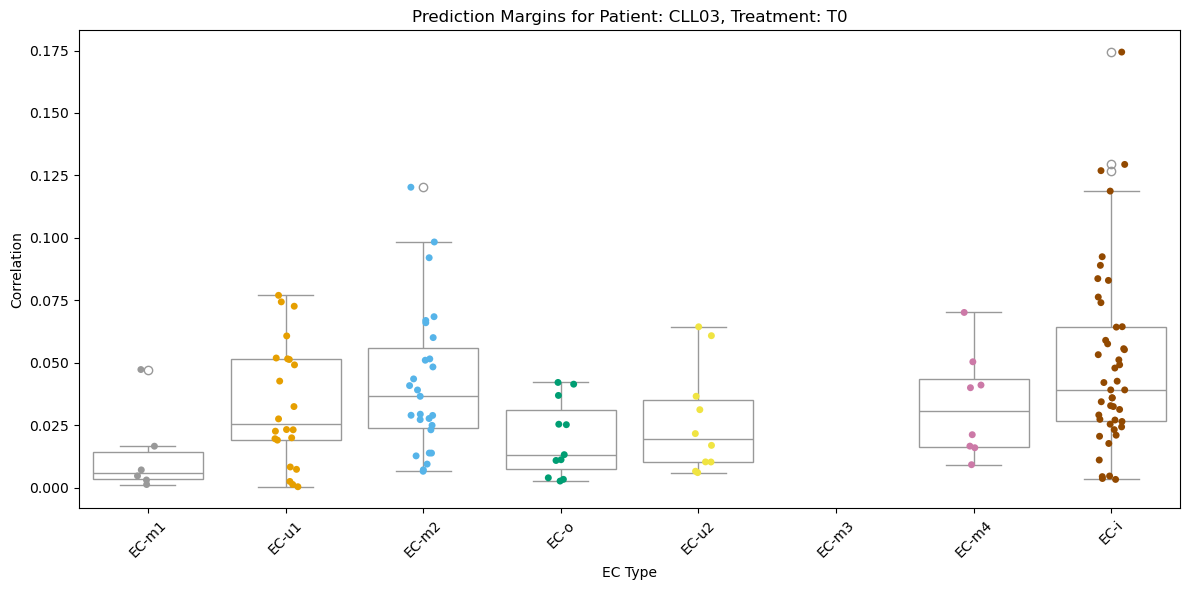

/tmp/ipykernel_974674/2778734476.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


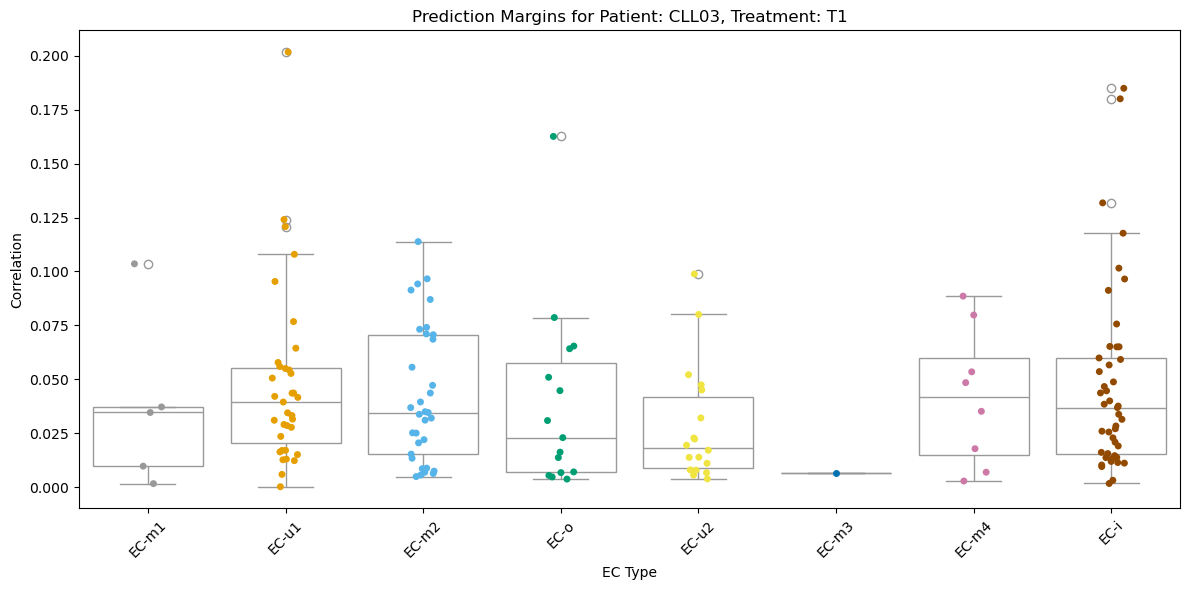

/tmp/ipykernel_974674/2778734476.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


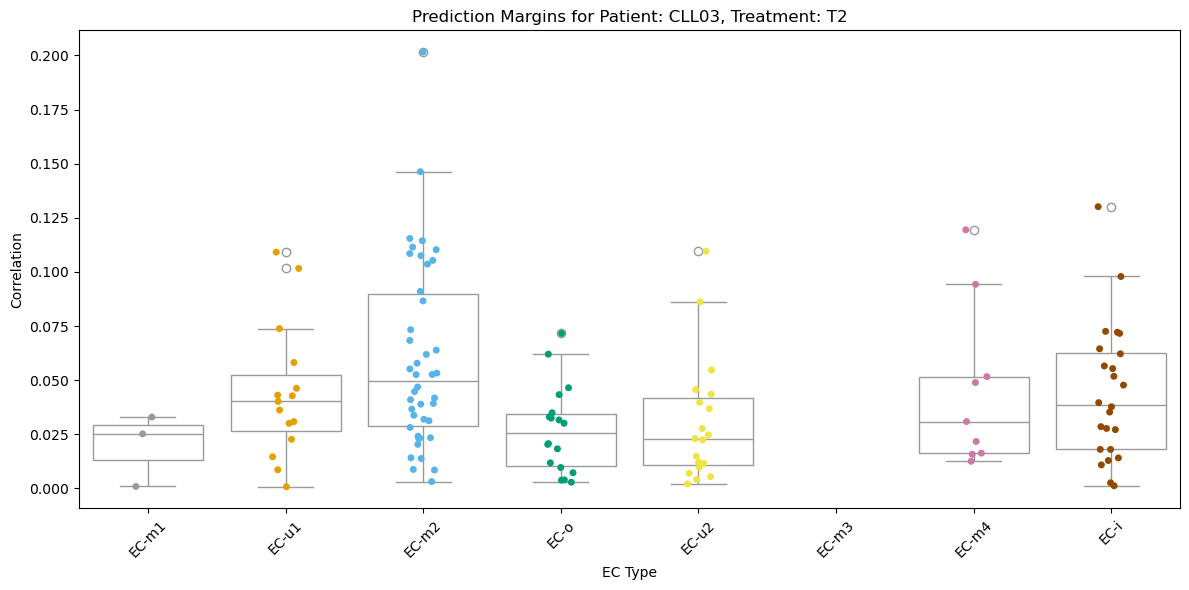

/tmp/ipykernel_974674/2778734476.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


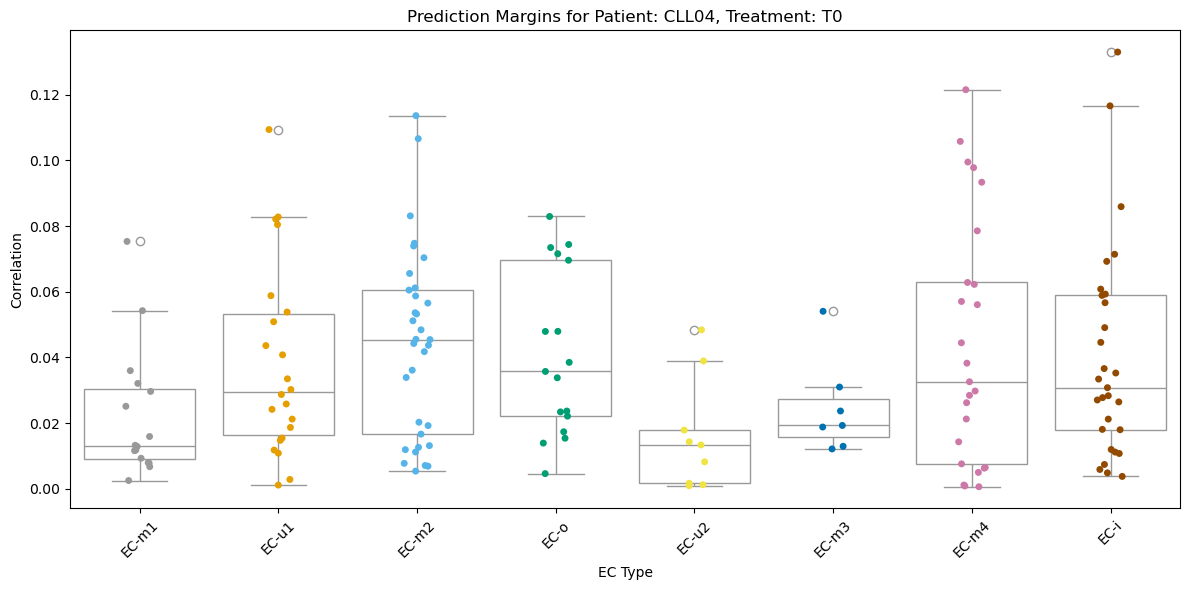

/tmp/ipykernel_974674/2778734476.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


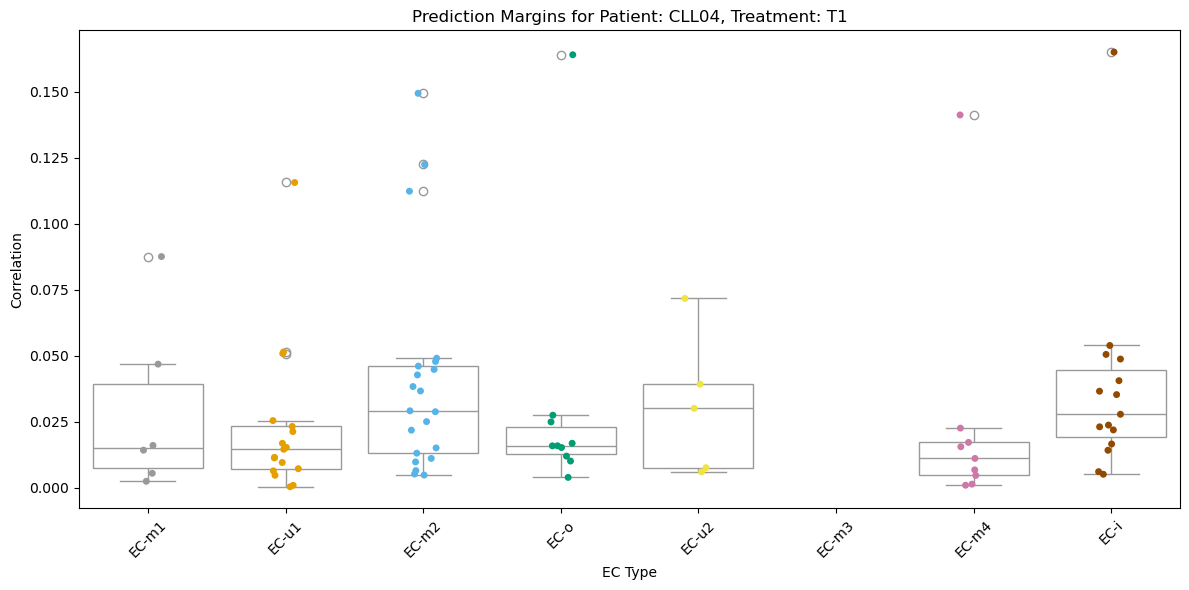

/tmp/ipykernel_974674/2778734476.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


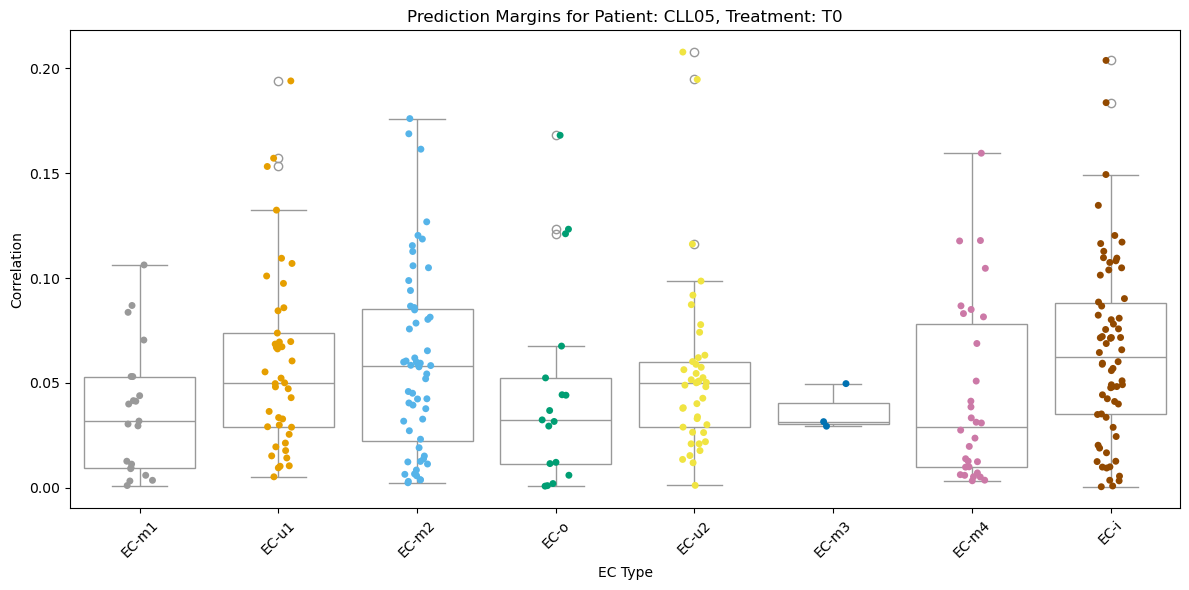

/tmp/ipykernel_974674/2778734476.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


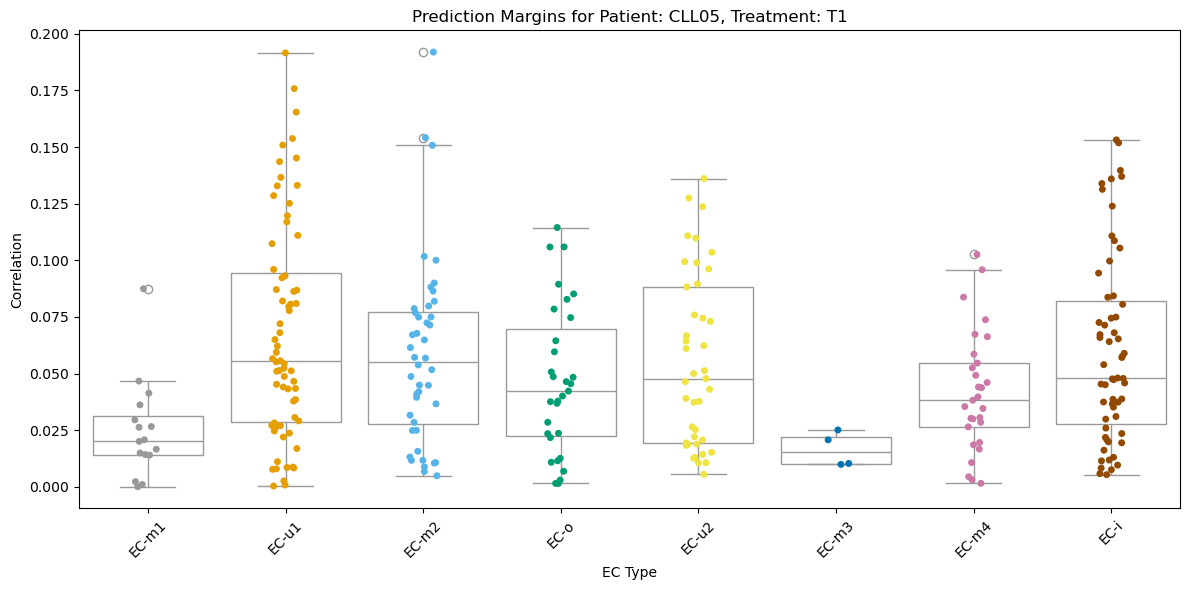

/tmp/ipykernel_974674/2778734476.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


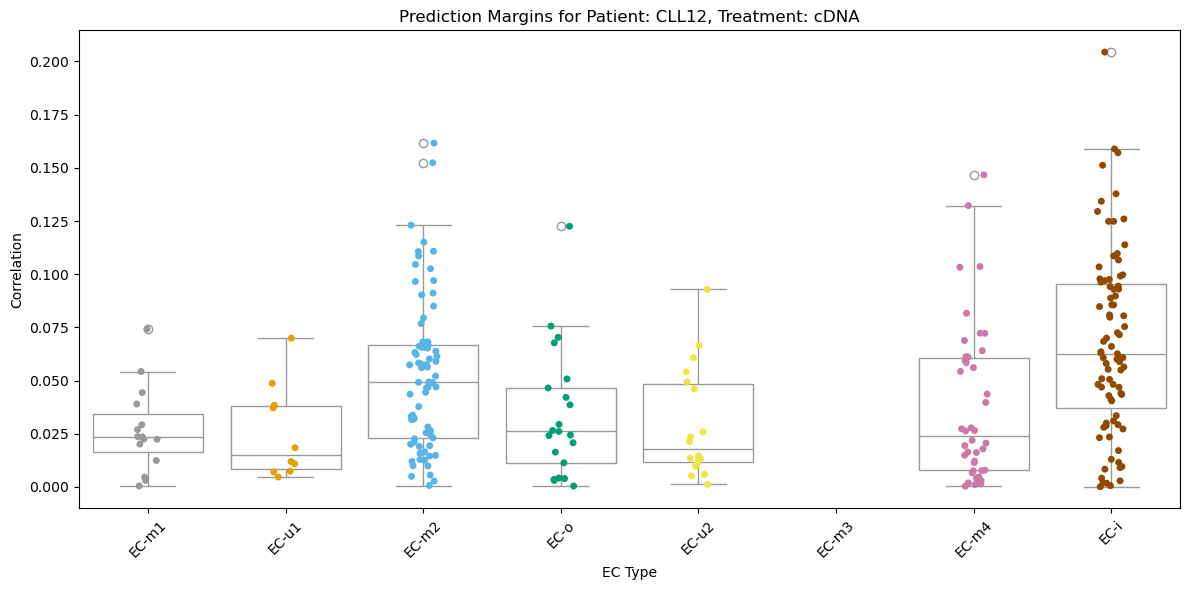

In [39]:
# Compute Spearman correlations
correlation_results = pd.DataFrame(index=adata_filtered.obs.index, columns=ec_profiles.columns)

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        # Check if there are NaNs in the data
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        # Check if the data is constant
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            # Ignore negative correlations
            if correlation < 0:
                correlations[ec_type] = np.nan
            else:
                correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Extract patient and treatment information from cell_name
correlation_results['Patient'] = correlation_results.index.str.split('_').str[0]
correlation_results['Treatment'] = correlation_results.index.str.split('_').str[1]

# Convert the DataFrame to a format suitable for Seaborn boxplot
plot_data = correlation_results.melt(id_vars=['Patient', 'Treatment'], var_name='EC', value_name='Correlation')

# Ensure EC types in plot_data match EC_NAMES
plot_data['EC'] = pd.Categorical(plot_data['EC'], categories=EC_NAMES, ordered=True)

# Plot the data for each patient and treatment status
for patient in plot_data['Patient'].unique():
    for treatment in plot_data['Treatment'].unique():
        subset_data = plot_data[(plot_data['Patient'] == patient) & (plot_data['Treatment'] == treatment)]
        if not subset_data.empty:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='EC', y='Correlation', data=subset_data, order=EC_NAMES, color='white', linewidth=1)
            sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)
            plt.xlabel('EC Type')
            plt.ylabel('Correlation')
            plt.title(f'Prediction Margins for Patient: {patient}, Treatment: {treatment}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

/tmp/ipykernel_974674/977355105.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


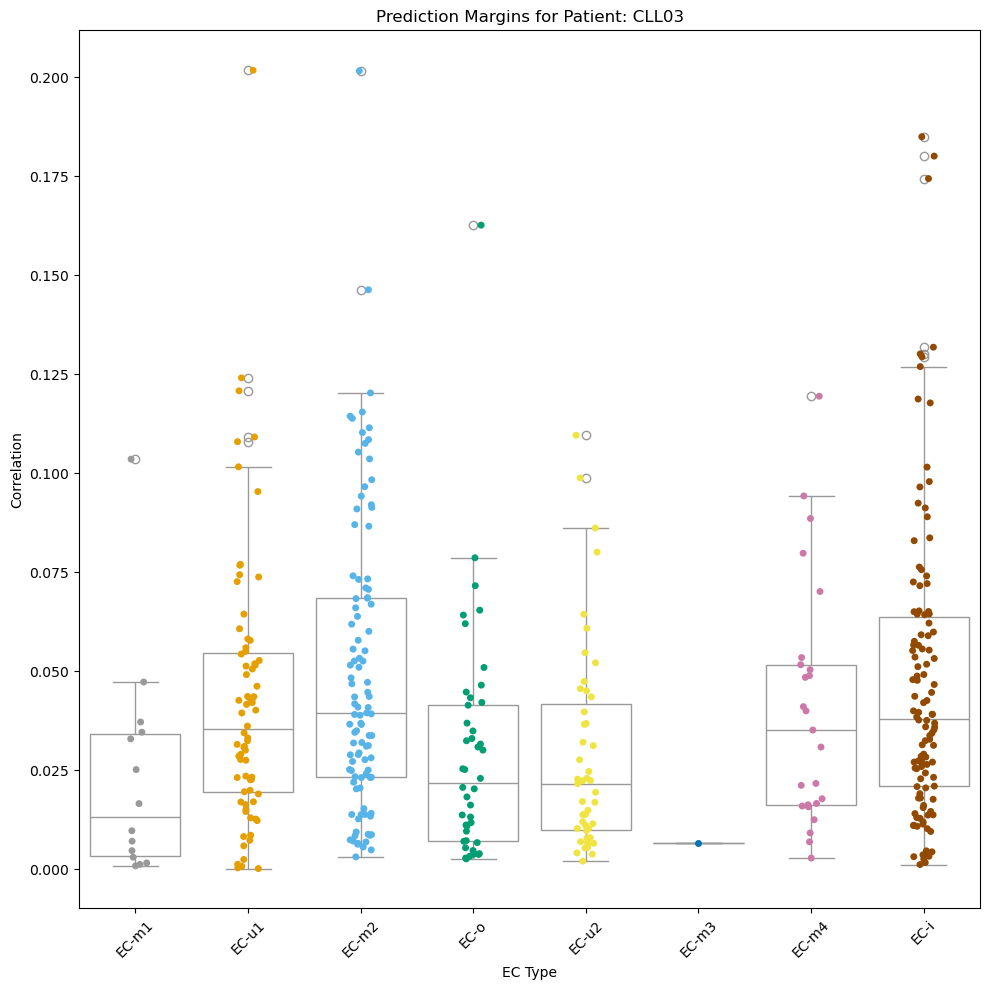

/tmp/ipykernel_974674/977355105.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


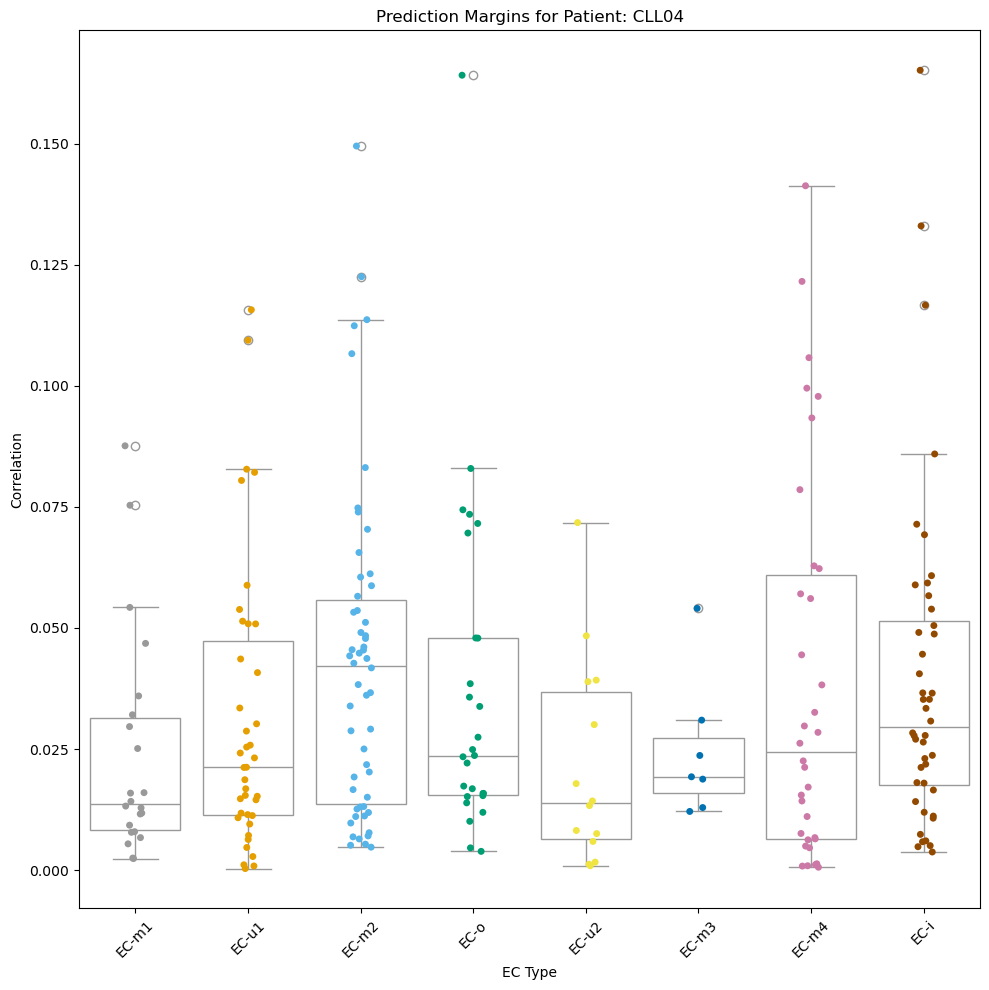

/tmp/ipykernel_974674/977355105.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


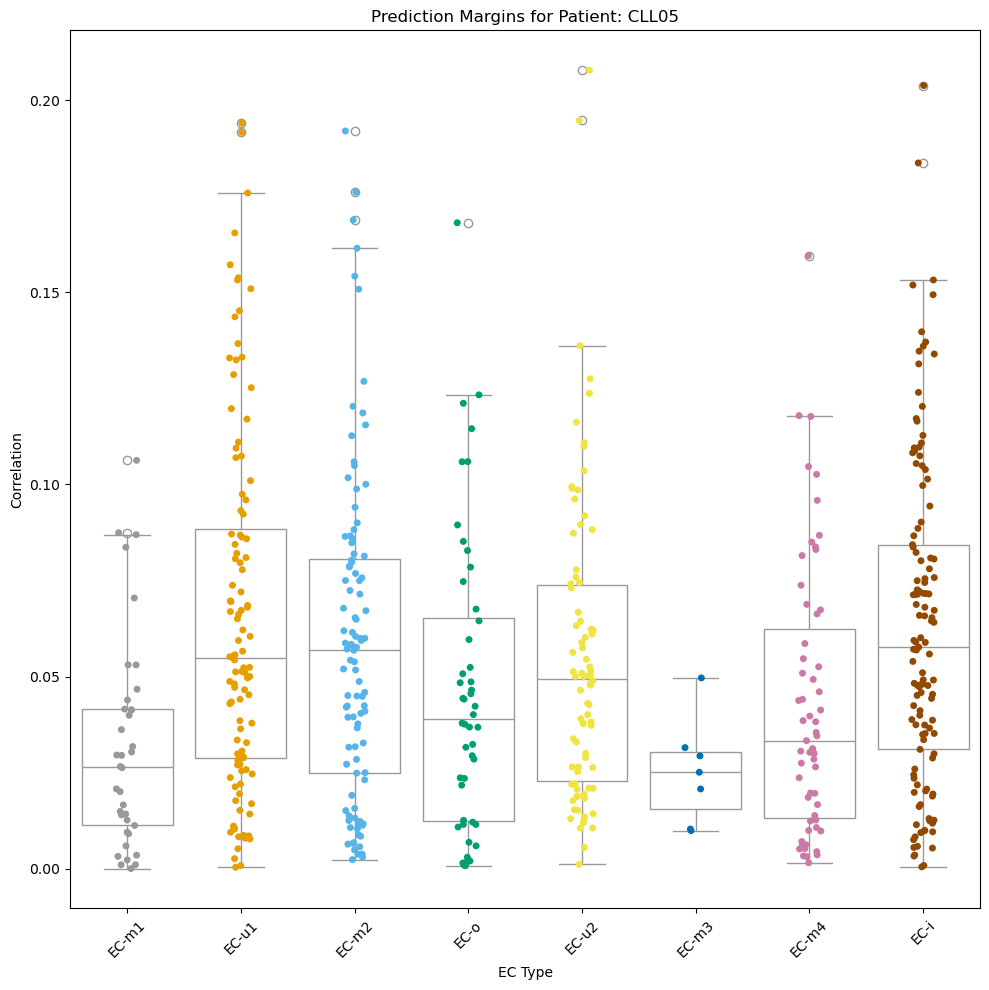

/tmp/ipykernel_974674/977355105.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


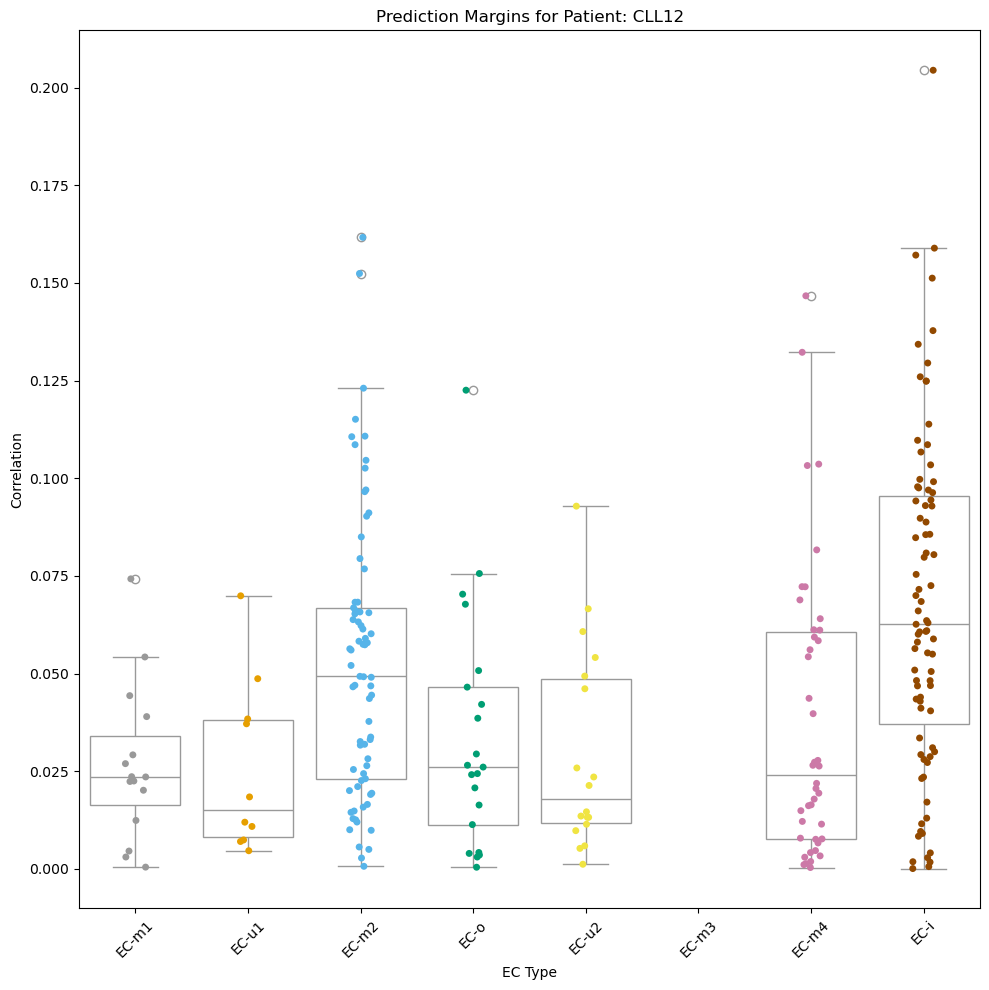

In [57]:
# Compute Spearman correlations
correlation_results = pd.DataFrame(index=adata_filtered.obs.index, columns=ec_profiles.columns)

# def compute_spearman_correlations(sample_expression, ec_profiles):
#     correlations = {}
#     for ec_type in ec_profiles.columns:
#         ec_expression = ec_profiles[ec_type]
#         # Check if there are NaNs in the data
#         if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
#             correlations[ec_type] = np.nan
#         # Check if the data is constant
#         elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
#             correlations[ec_type] = np.nan
#         else:
#             correlation, _ = spearmanr(sample_expression, ec_expression)
#             correlations[ec_type] = correlation
#     return correlations

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        # Check if there are NaNs in the data
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        # Check if the data is constant
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            # Ignore negative correlations
            if correlation < 0:
                correlations[ec_type] = np.nan
            else:
                correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Extract patient and treatment information from cell_name
correlation_results['Patient'] = correlation_results.index.str.split('_').str[0]
correlation_results['Treatment'] = correlation_results.index.str.split('_').str[1]

# Convert the DataFrame to a format suitable for Seaborn boxplot
plot_data = correlation_results.melt(id_vars=['Patient', 'Treatment'], var_name='EC', value_name='Correlation')

# Ensure EC types in plot_data match EC_NAMES
plot_data['EC'] = pd.Categorical(plot_data['EC'], categories=EC_NAMES, ordered=True)

# Plot the data for each patient and treatment status
for patient in plot_data['Patient'].unique():
    subset_data = plot_data[(plot_data['Patient'] == patient)]
    if not subset_data.empty:
        plt.figure(figsize=(10, 10))
        sns.boxplot(x='EC', y='Correlation', data=subset_data, order=EC_NAMES, color='white', linewidth=1)
        sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)
        plt.xlabel('EC Type')
        plt.ylabel('Correlation')
        plt.title(f'Prediction Margins for Patient: {patient}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_974674/344665949.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


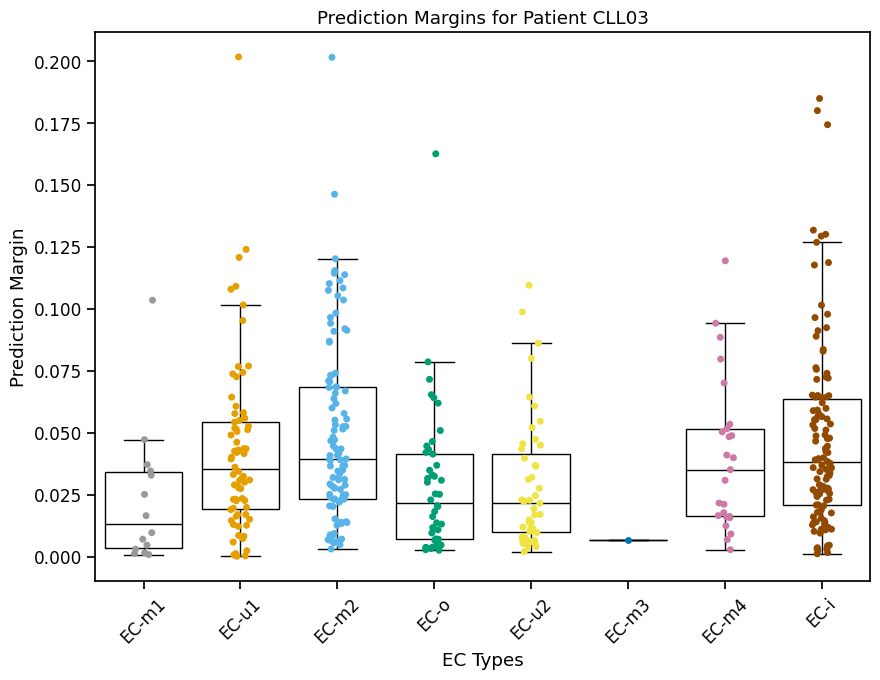

/tmp/ipykernel_974674/344665949.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


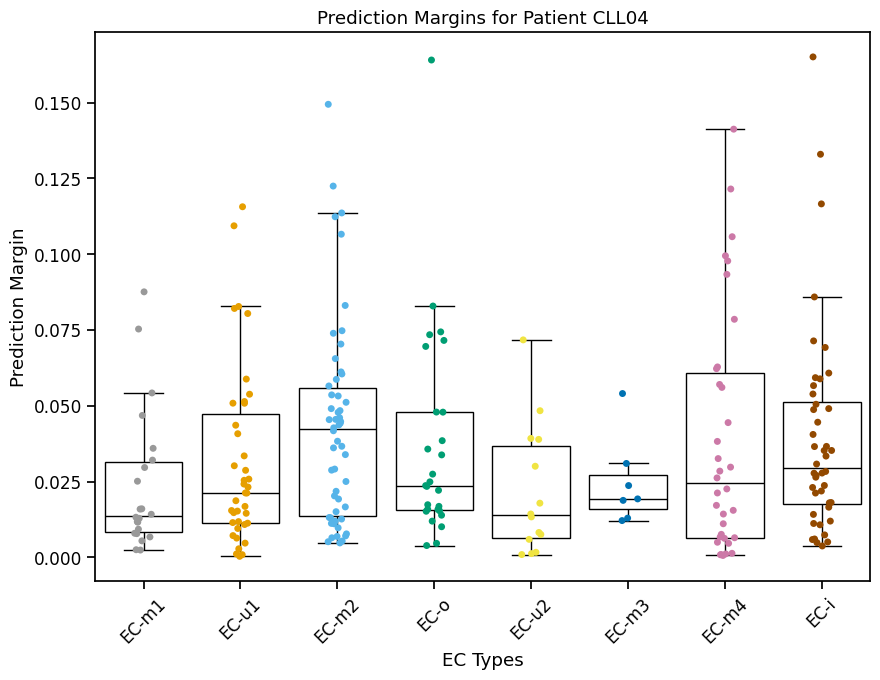

/tmp/ipykernel_974674/344665949.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


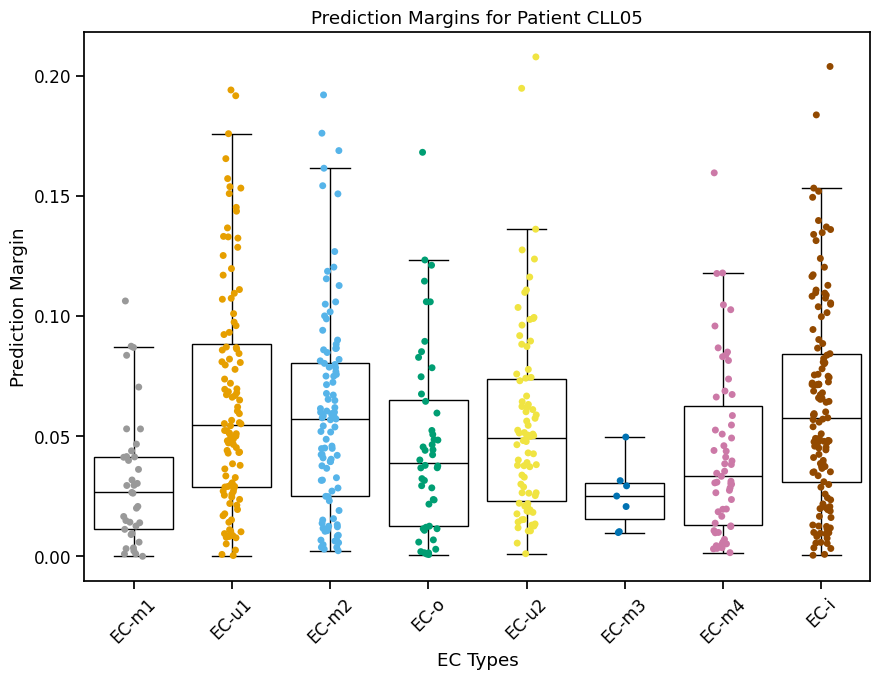

/tmp/ipykernel_974674/344665949.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


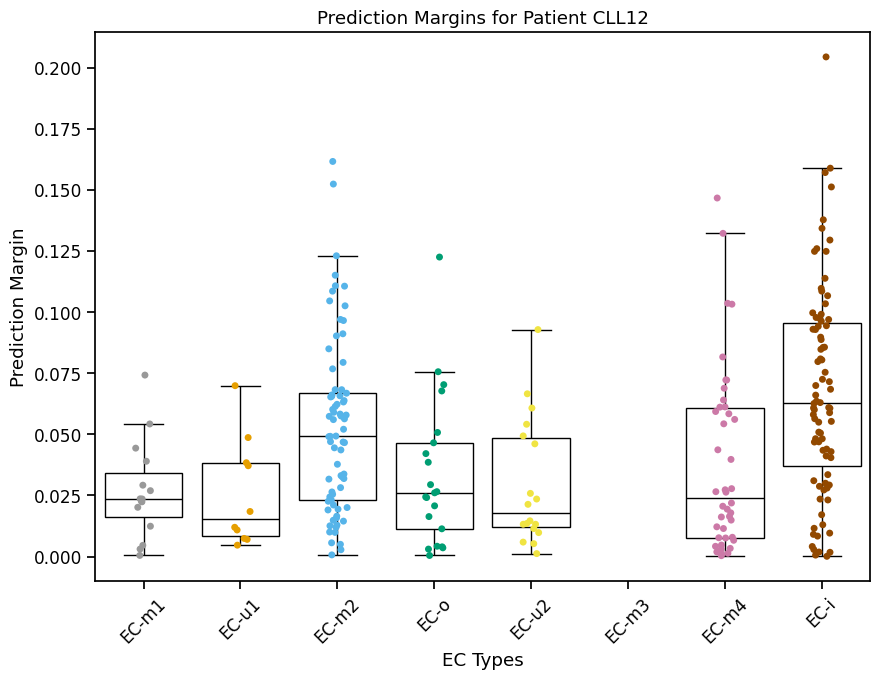

In [61]:
def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        # Check if there are NaNs in the data
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        # Check if the data is constant
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            # Ignore negative correlations
            if correlation < 0:
                correlations[ec_type] = np.nan
            else:
                correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Extract patient information from cell_name
correlation_results['Patient'] = correlation_results.index.str.split('_').str[0]

# Convert the DataFrame to a format suitable for Seaborn boxplot
plot_data = correlation_results.melt(id_vars=['Patient'], var_name='EC', value_name='Correlation')

# Ensure EC types in plot_data match EC_NAMES
plot_data['EC'] = pd.Categorical(plot_data['EC'], categories=EC_NAMES, ordered=True)

# Convert Correlation column to numeric, coerce errors
plot_data['Correlation'] = pd.to_numeric(plot_data['Correlation'], errors='coerce')

# Drop rows with NaN values in Correlation column
plot_data = plot_data.dropna(subset=['Correlation'])

sns.set_context("notebook", font_scale=1.1)

# Plot the data for each patient
for patient in plot_data['Patient'].unique():
    subset_data = plot_data[plot_data['Patient'] == patient]
    if not subset_data.empty:
        plt.figure(figsize=(9, 7))
        sns.boxplot(
            x='EC', y='Correlation', data=subset_data, order=EC_NAMES, 
            boxprops=dict(facecolor='white', edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'),
            showfliers=False
        )
        sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)
        plt.xlabel('EC Types')
        plt.ylabel('Prediction Margin')
        plt.title(f'Prediction Margins for Patient {patient}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_974674/358576377.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


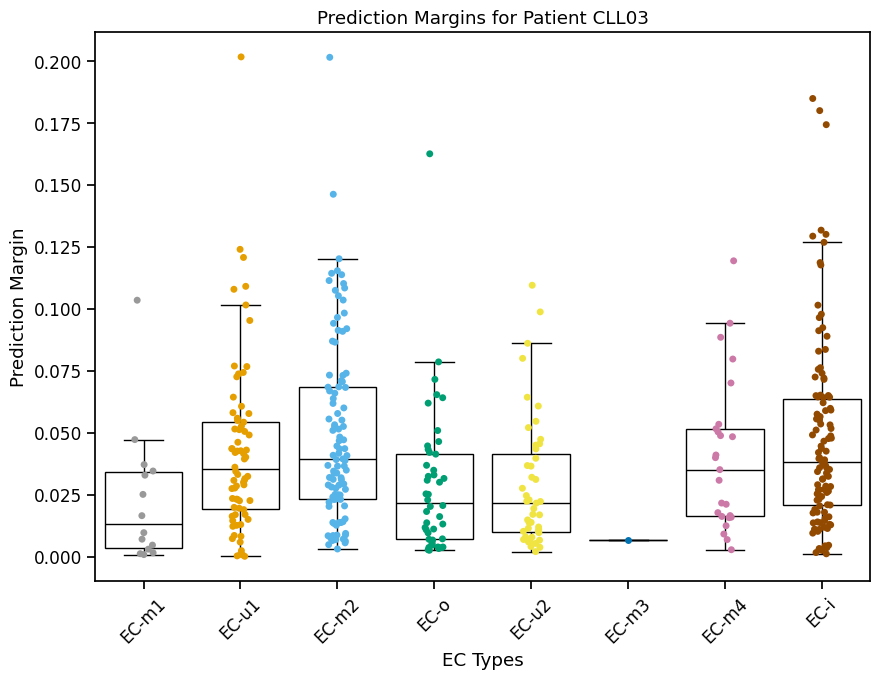

/tmp/ipykernel_974674/358576377.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


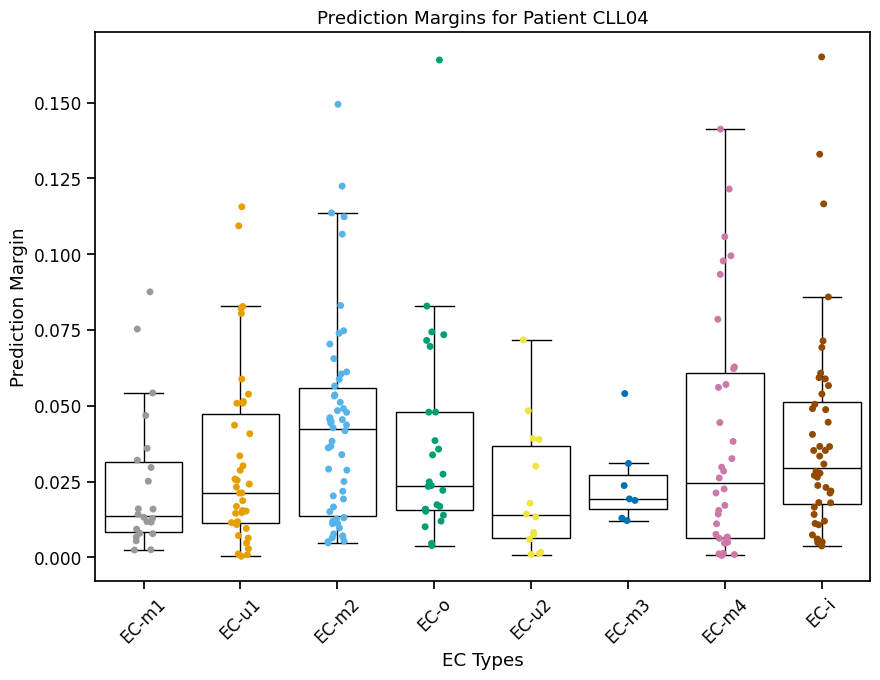

/tmp/ipykernel_974674/358576377.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


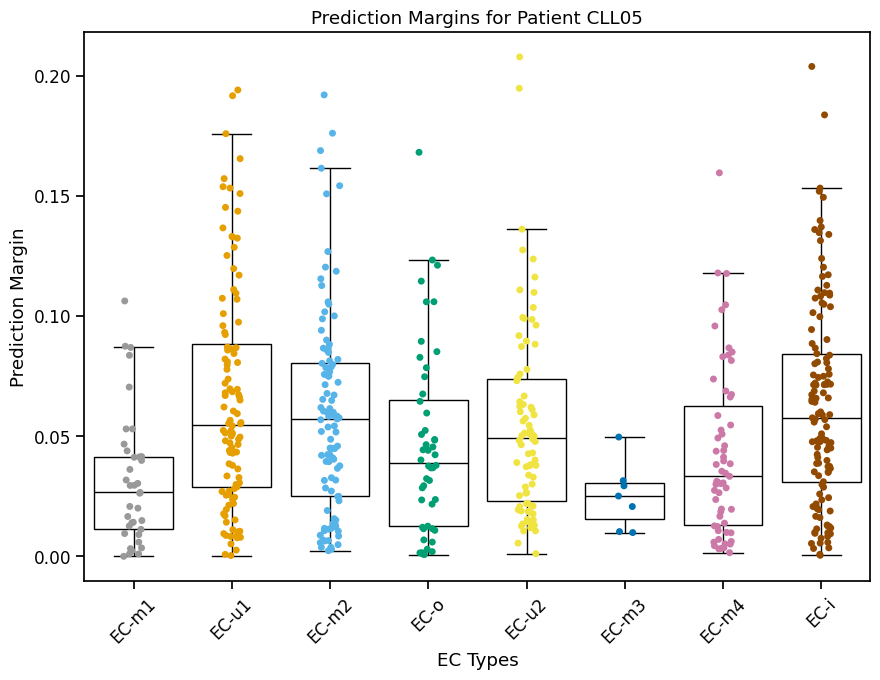

/tmp/ipykernel_974674/358576377.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


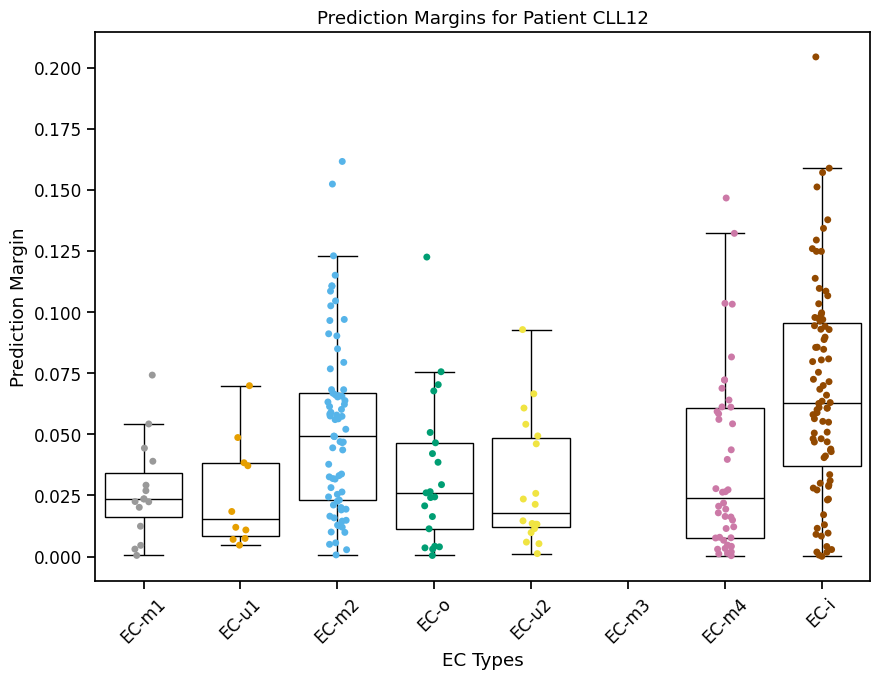

/tmp/ipykernel_974674/358576377.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  patient_ec_distribution = plot_data.groupby(['Patient', 'EC']).size().unstack(fill_value=0)
/tmp/ipykernel_974674/358576377.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLORS)


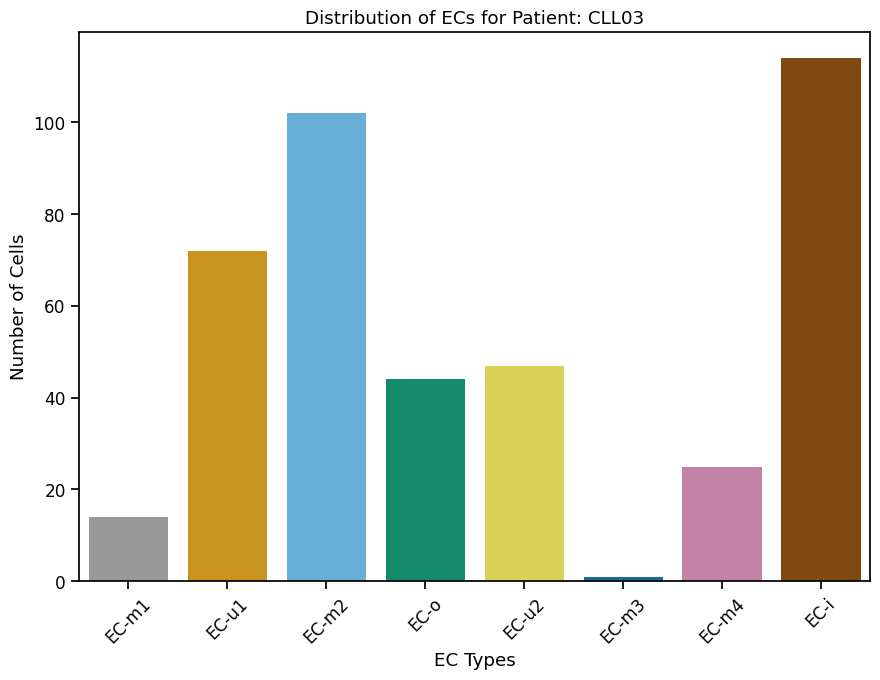

/tmp/ipykernel_974674/358576377.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLORS)


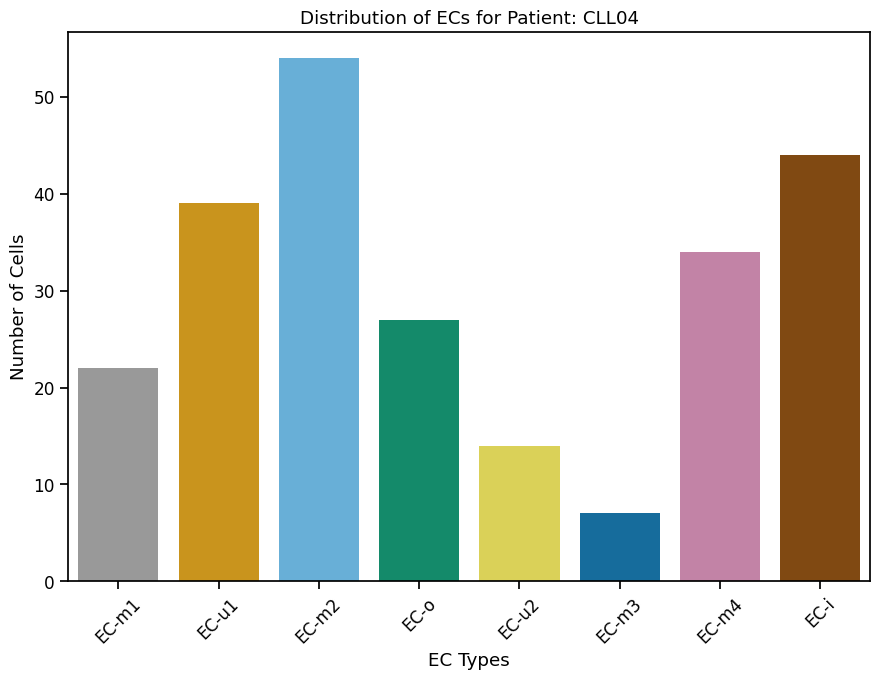

/tmp/ipykernel_974674/358576377.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLORS)


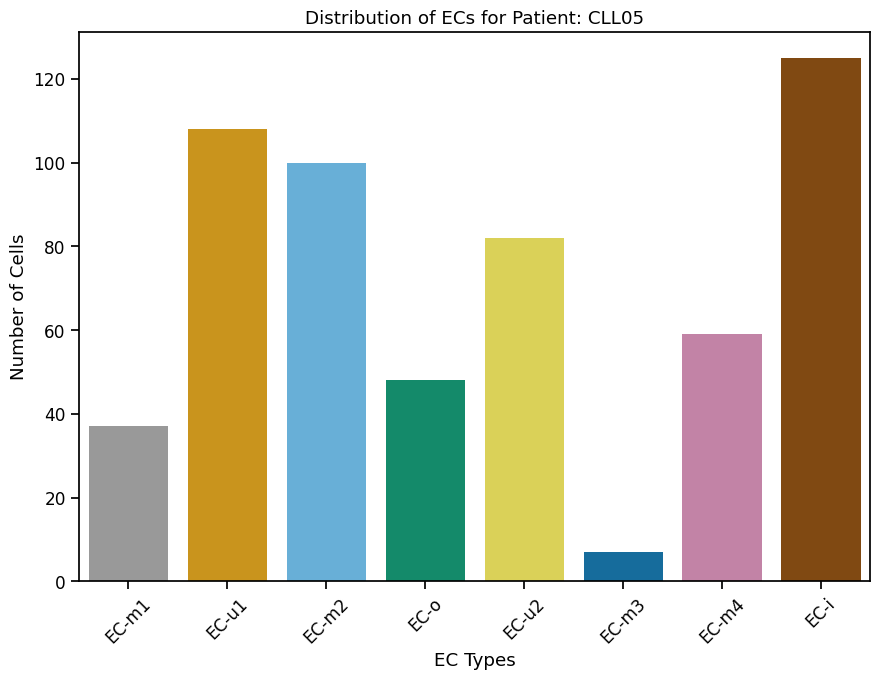

/tmp/ipykernel_974674/358576377.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLORS)


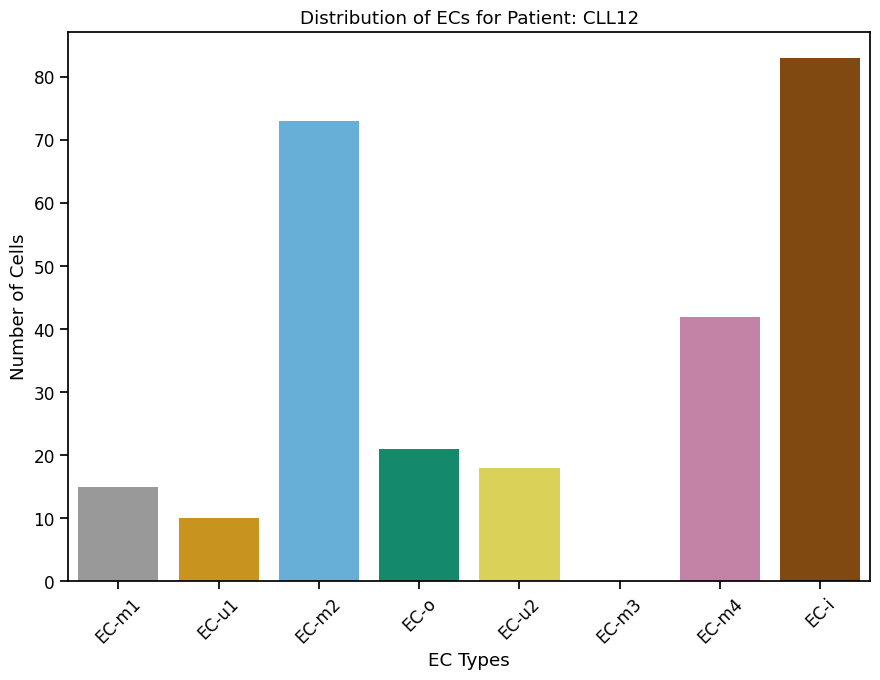

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Previous steps (already provided)
def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        # Check if there are NaNs in the data
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        # Check if the data is constant
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            # Ignore negative correlations
            if correlation < 0:
                correlations[ec_type] = np.nan
            else:
                correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Extract patient information from cell_name
correlation_results['Patient'] = correlation_results.index.str.split('_').str[0]

# Convert the DataFrame to a format suitable for Seaborn boxplot
plot_data = correlation_results.melt(id_vars=['Patient'], var_name='EC', value_name='Correlation')

# Ensure EC types in plot_data match EC_NAMES
plot_data['EC'] = pd.Categorical(plot_data['EC'], categories=EC_NAMES, ordered=True)

# Convert Correlation column to numeric, coerce errors
plot_data['Correlation'] = pd.to_numeric(plot_data['Correlation'], errors='coerce')

# Drop rows with NaN values in Correlation column
plot_data = plot_data.dropna(subset=['Correlation'])

sns.set_context("notebook", font_scale=1.1)

# Plot the data for each patient using boxplots
for patient in plot_data['Patient'].unique():
    subset_data = plot_data[plot_data['Patient'] == patient]
    if not subset_data.empty:
        plt.figure(figsize=(9, 7))
        sns.boxplot(
            x='EC', y='Correlation', data=subset_data, order=EC_NAMES, 
            boxprops=dict(facecolor='white', edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'),
            showfliers=False
        )
        sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)
        plt.xlabel('EC Types')
        plt.ylabel('Prediction Margin')
        plt.title(f'Prediction Margins for Patient {patient}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# New Step: Plot bar plots for the distribution of EC types for each patient

# Group by patient and EC type to get the count of cells for each EC type per patient
patient_ec_distribution = plot_data.groupby(['Patient', 'EC']).size().unstack(fill_value=0)

# Plot the distribution of EC types for each patient
for patient in patient_ec_distribution.index:
    plt.figure(figsize=(9, 7))
    patient_data = patient_ec_distribution.loc[patient].reindex(EC_NAMES, fill_value=0)
    
    # Plotting the bar plot
    sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLORS)
    
    plt.title(f'Distribution of ECs for Patient: {patient}')
    plt.xlabel('EC Types')
    plt.ylabel('Number of Cells')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
np.mean(highest_correlation_list), np.std(highest_correlation_list)

(0.021075725654479373, 0.0688981170724195)

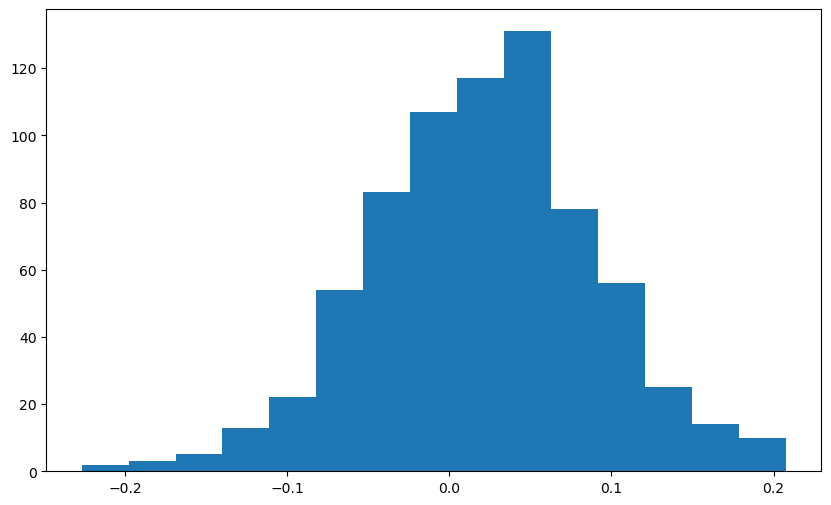

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(highest_correlation_list, bins=15)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.stats import spearmanr

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Define the desired order for the columns
desired_order = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]

# Load the normalized single-cell data
check = sc.read_h5ad("raw_data/sc_cll_3ca.h5ad")

# List of genes to keep
descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]

# Filter the AnnData object to include only the selected genes
adata_filtered = check[:, check.var.index.isin(descriptions_to_keep)]
print(adata_filtered.obs)

# Calculate the EC profiles
ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])

# Compute Spearman correlation for each sample
correlation_results = pd.DataFrame(index=adata_filtered.obs.index, columns=ec_profiles.columns)

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Ensure all values in correlation_results are numeric
correlation_results = correlation_results.apply(pd.to_numeric, errors='coerce')

# Calculate prediction margins
def calculate_prediction_margin(row):
    if row.isnull().all():
        return np.nan
    sorted_values = row.sort_values(ascending=False)
    if len(sorted_values) < 2:
        return np.nan
    return sorted_values.iloc[0] - sorted_values.iloc[1]

prediction_margins = correlation_results.apply(calculate_prediction_margin, axis=1)

# Create a DataFrame for plotting
df = correlation_results.idxmax(axis=1).reset_index()
df.columns = ['Sample_ID', 'Predicted_EC']
df['Prediction_Margin'] = prediction_margins.values

# Assuming 'patient_id' is in the obs DataFrame of adata_filtered
df['Patient_ID'] = adata_filtered.obs['patient'].values  # Adjust to your actual column name for patient IDs


# # Create box plots per patient with columns representing each EC
unique_patients = df['Patient_ID'].unique()
# for patient in unique_patients:
#     plt.figure(figsize=(8, 6))
#     # patient_df = df[df['Patient_ID'] == 'patient']
#     sns.boxplot(x='Predicted_EC', y='Prediction_Margin', data=df, palette=EC_COLORS, order=desired_order)
#     plt.xlabel('EC')
#     plt.ylabel('Prediction Margin')
#     plt.xticks(rotation=45)
#     plt.show()

for patient in unique_patients:
    plt.figure(figsize=(8, 6))
    # patient_df = df[df['Patient_ID'] == patient]
    sns.boxplot(
        x='Predicted_EC', 
        y='Prediction_Margin', 
        data=df, 
        palette=EC_COLORS, 
        order=desired_order,
        whis=[0, 100],  # Extend whiskers to the min and max data points
        fliersize=5, 
        linewidth=1.5, 
        showfliers=True, 
        boxprops=dict(facecolor="white", edgecolor='black'), 
        whiskerprops=dict(linewidth=1.5, color='black')
    )
    sns.stripplot(
        x='Predicted_EC', 
        y='Prediction_Margin', 
        data=df, 
        hue='Predicted_EC', 
        palette=EC_COLORS, 
        dodge=False, 
        jitter=True, 
        size=5
    )
    plt.xlabel('EC Types')
    plt.ylabel('Prediction Margin')
    plt.title(f'Prediction Margins for Patient {patient}')
    plt.xticks(rotation=45)
    plt.legend(title='EC Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    


                                     sample patient  sample_status  complexity
cell_name                                                                     
CLL03_T0_cDNA_A10_S202  CLL03_pre_treatment   CLL03  pre_treatment        4941
CLL03_T0_cDNA_A11_S203  CLL03_pre_treatment   CLL03  pre_treatment        6307
CLL03_T0_cDNA_A12_S204  CLL03_pre_treatment   CLL03  pre_treatment        2939
CLL03_T0_cDNA_A1_S193   CLL03_pre_treatment   CLL03  pre_treatment        7023
CLL03_T0_cDNA_A2_S194   CLL03_pre_treatment   CLL03  pre_treatment        6222
...                                     ...     ...            ...         ...
CLL12_cDNA_H5_S185      CLL12_pre_treatment   CLL12  pre_treatment        1961
CLL12_cDNA_H6_S186      CLL12_pre_treatment   CLL12  pre_treatment        5563
CLL12_cDNA_H7_S187      CLL12_pre_treatment   CLL12  pre_treatment        5844
CLL12_cDNA_H9_S189      CLL12_pre_treatment   CLL12  pre_treatment        3733
CLL12_cDNA_H8_S188      CLL12_pre_treatment   CLL12 

NameError: name 'adata_combined_normalized' is not defined

In [ ]:
closest_ec_types_per_sample

{'CLL03_T0_cDNA_A10_S202': ['EC-i'],
 'CLL03_T0_cDNA_A11_S203': ['EC-i'],
 'CLL03_T0_cDNA_A12_S204': ['EC-u2'],
 'CLL03_T0_cDNA_A1_S193': ['EC-u1'],
 'CLL03_T0_cDNA_A2_S194': ['EC-m2'],
 'CLL03_T0_cDNA_A3_S195': ['EC-m2'],
 'CLL03_T0_cDNA_A4_S196': ['EC-m2'],
 'CLL03_T0_cDNA_A5_S197': ['EC-i'],
 'CLL03_T0_cDNA_A6_S198': ['EC-o'],
 'CLL03_T0_cDNA_A7_S199': ['EC-i'],
 'CLL03_T0_cDNA_A8_S200': ['EC-i'],
 'CLL03_T0_cDNA_A9_S201': ['EC-m1'],
 'CLL03_T0_cDNA_B10_S214': ['EC-u1'],
 'CLL03_T0_cDNA_B11_S215': ['EC-m2'],
 'CLL03_T0_cDNA_B12_S216': ['EC-m2'],
 'CLL03_T0_cDNA_B1_S205': ['EC-m1'],
 'CLL03_T0_cDNA_B2_S206': ['EC-m2'],
 'CLL03_T0_cDNA_B3_S207': ['EC-m4'],
 'CLL03_T0_cDNA_B4_S208': ['EC-m2'],
 'CLL03_T0_cDNA_B5_S209': ['EC-i'],
 'CLL03_T0_cDNA_B6_S210': ['EC-i'],
 'CLL03_T0_cDNA_B7_S211': ['EC-i'],
 'CLL03_T0_cDNA_B8_S212': ['EC-m3'],
 'CLL03_T0_cDNA_B9_S213': ['EC-o'],
 'CLL03_T0_cDNA_C10_S226': ['EC-i'],
 'CLL03_T0_cDNA_C11_S227': ['EC-i'],
 'CLL03_T0_cDNA_C12_S228': ['EC-i'],
 'CLL

ValueError: The palette dictionary is missing keys: {Ellipsis}

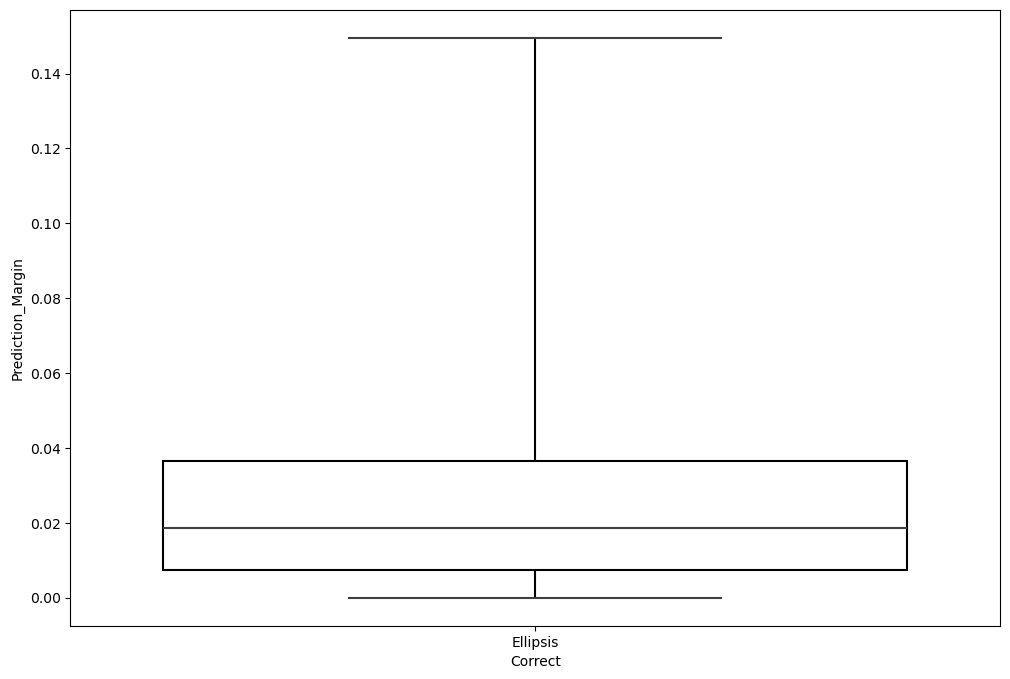

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Define the desired order for the columns
desired_order = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]

# Assuming 'correlation_results' DataFrame is defined somewhere in your code
# Ensure all values in correlation_results are numeric
correlation_results = correlation_results.apply(pd.to_numeric, errors='coerce')

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Prediction_Margin': correlation_results.max(axis=1) - correlation_results.apply(lambda x: x.nlargest(2).iloc[-1], axis=1),
    'Correct': ...,  # Add your 'Correct' data here
    'EC_Type': ...  # Add your 'EC_Type' data here
})

# Calculate the IQR and determine the appropriate y-axis limits
q1 = df['Prediction_Margin'].quantile(0.25)
q3 = df['Prediction_Margin'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr + 0.2

# Combined box plot with all ECs together
plt.figure(figsize=(12, 8))

# Box plot with outliers and outline color
sns.boxplot(
    x='Correct', 
    y='Prediction_Margin', 
    data=df, 
    fliersize=5, 
    linewidth=1.5, 
    showfliers=True, 
    boxprops=dict(facecolor="white", edgecolor='black'), 
    whiskerprops=dict(linewidth=1.5, color='black'),
    whis=[0, 100]  # Adjust this parameter to extend whiskers to the min and max data points
)

# Strip plot to add individual data points
sns.stripplot(
    x='Correct',  # x-axis based on 'Correct' column
    y='Prediction_Margin',  # y-axis based on 'Prediction_Margin' column
    hue='EC_Type',  # Color dots based on 'EC_Type'
    data=df,  # DataFrame containing the data
    palette=EC_COLORS,  # Use the predefined color palette for EC types
    dodge=False,  # Do not separate dots based on hue
    alpha=0.7,  # Transparency of dots
    jitter=True,  # Add jitter to x-axis positions to avoid overlap
    size=5  # Match the size of the outlier points
)

# Set y-axis limit to make the box smaller and focus on the main distribution
plt.ylim(-0.1, upper_bound)

plt.xlabel('Correct')
plt.ylabel('Prediction Margin (Best - 2nd)')
plt.title('Prediction Margin')
plt.legend(title='EC Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Individual box plots for each EC type
fig, axes = plt.subplots(4, 2, figsize=(20, 16), sharey=True)
axes = axes.flatten()

for ax, ec in zip(axes, desired_order):
    sns.boxplot(
        x='Correct', 
        y='Prediction_Margin', 
        data=df[df['EC_Type'] == ec], 
        ax=ax, 
        palette=[EC_COLORS[ec]], 
        fliersize=5, 
        linewidth=1.5, 
        showfliers=True, 
        boxprops=dict(facecolor="white", edgecolor='black'), 
        whiskerprops=dict(linewidth=1.5, color='black'),
        whis=[0, 100]  # Adjust this parameter to extend whiskers to the min and max data points
    )
    sns.stripplot(
        x='Correct', 
        y='Prediction_Margin', 
        data=df[df['EC_Type'] == ec], 
        ax=ax, 
        color=EC_COLORS[ec], 
        dodge=False, 
        alpha=0.7, 
        jitter=True, 
        size=5
    )
    ax.set_ylim(-0.1, upper_bound)
    ax.set_title(f'Prediction Margin for {ec}')
    ax.set_xlabel('Correct')
    ax.set_ylabel('Prediction Margin (Best - 2nd)')

plt.tight_layout()
plt.show()

{'EC-m1': '#999999', 'EC-u1': '#E69F00', 'EC-m2': '#56B4E9', 'EC-o': '#009E73', 'EC-u2': '#F0E442', 'EC-m3': '#0072B2', 'EC-m4': '#CC79A7', 'EC-i': '#924900'}


/tmp/ipykernel_1328300/4240445903.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='EC_Type', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


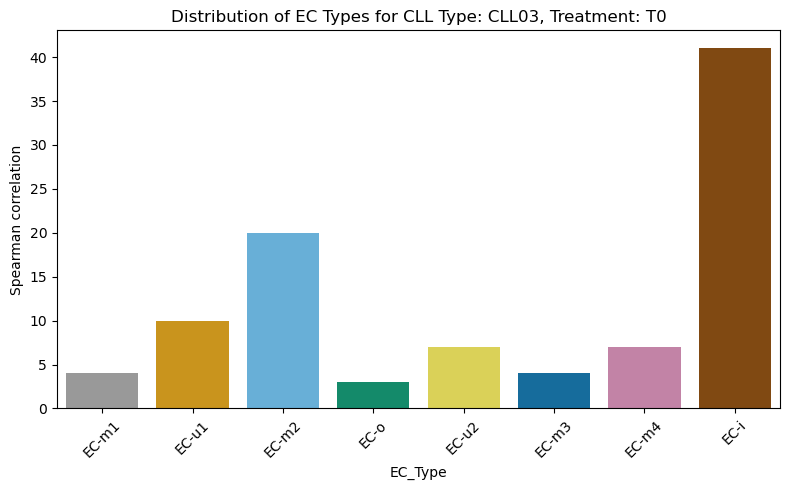

/tmp/ipykernel_1328300/4240445903.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='EC_Type', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


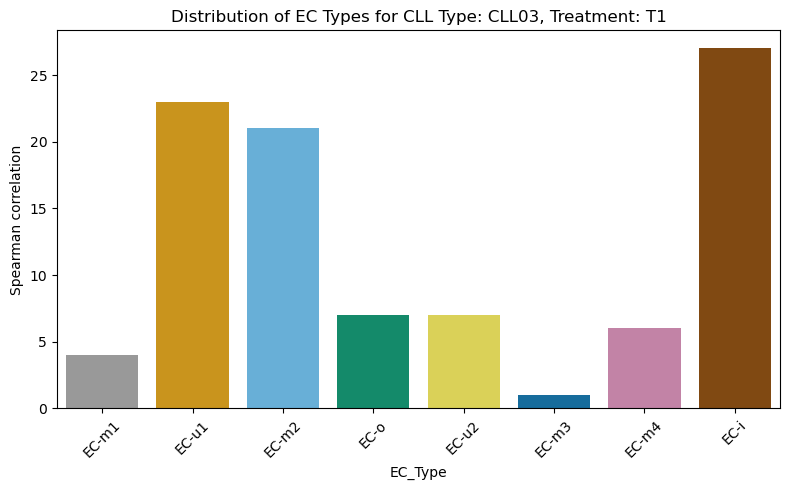

/tmp/ipykernel_1328300/4240445903.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='EC_Type', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


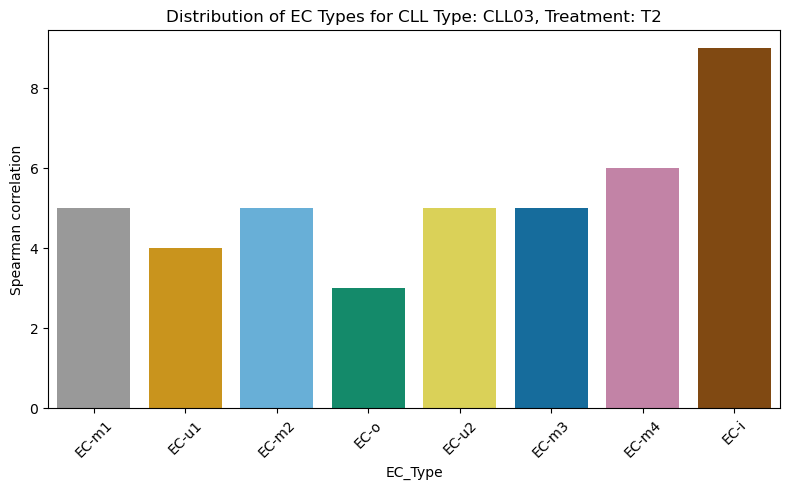

/tmp/ipykernel_1328300/4240445903.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='EC_Type', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


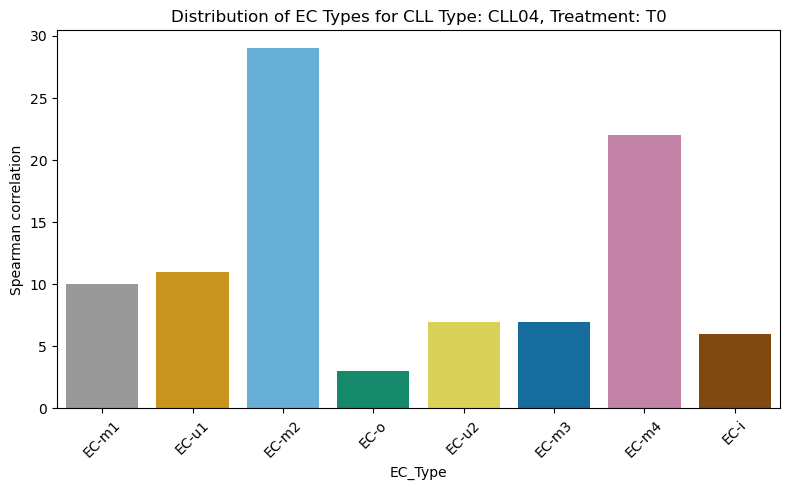

/tmp/ipykernel_1328300/4240445903.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='EC_Type', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


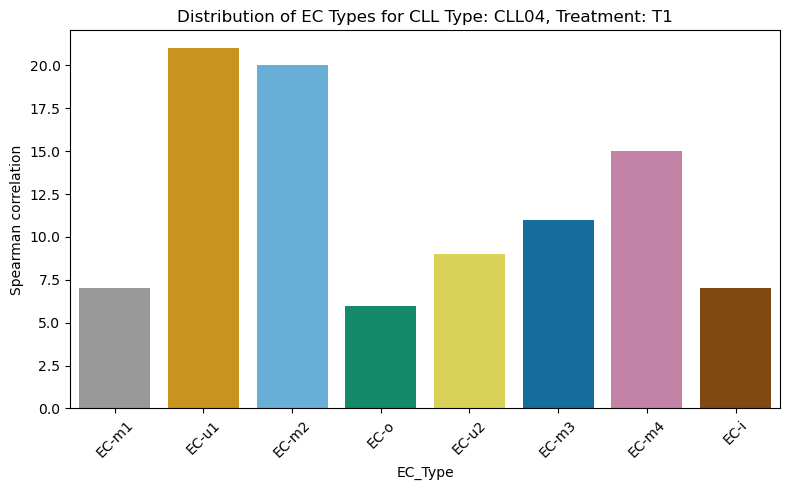

/tmp/ipykernel_1328300/4240445903.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='EC_Type', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


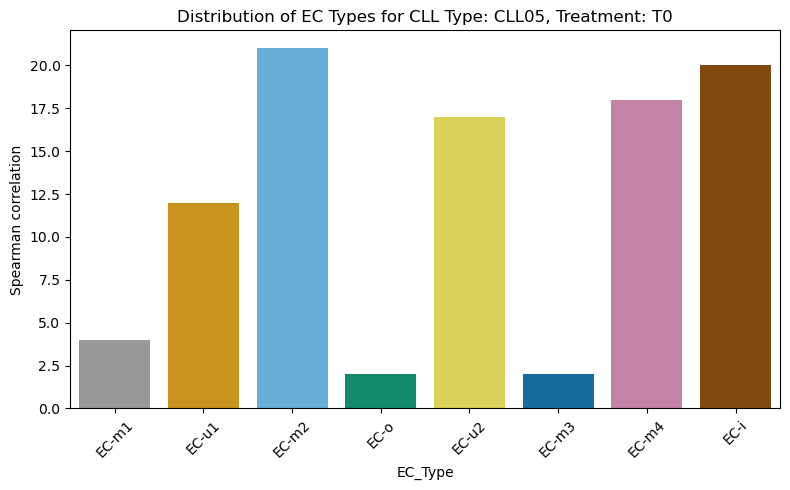

/tmp/ipykernel_1328300/4240445903.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='EC_Type', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


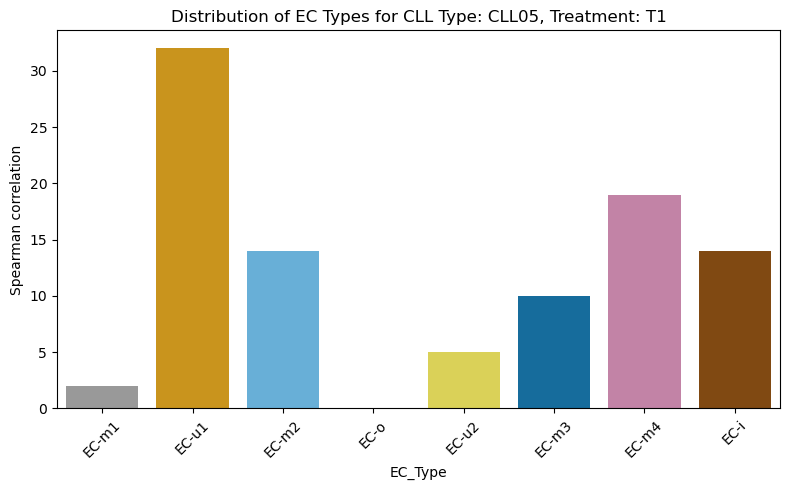

/tmp/ipykernel_1328300/4240445903.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='EC_Type', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


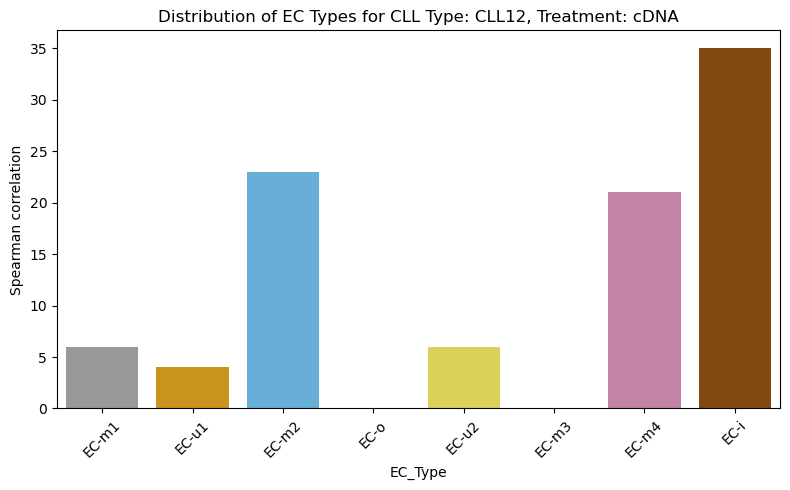

/tmp/ipykernel_1328300/4240445903.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='EC_Type', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


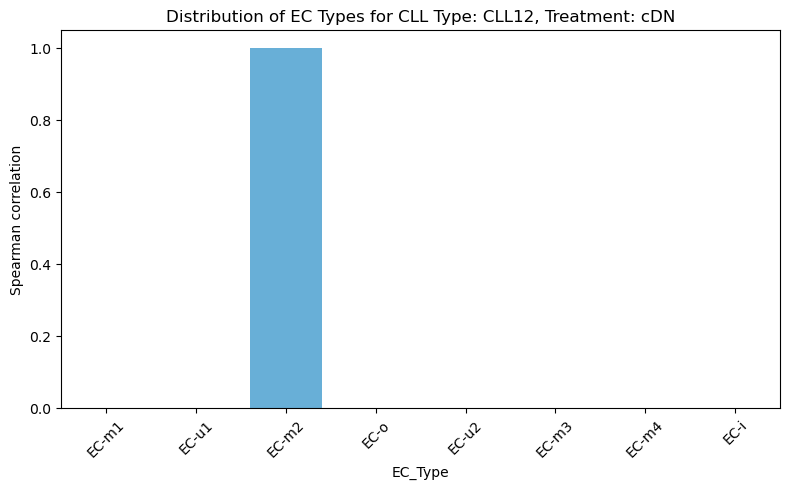

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to map each sample to its highest EC type
closest_ec_types_per_sample["CLL03_T2_c48"] = ['EC-m3']
sample_to_ec_type = pd.DataFrame.from_dict(closest_ec_types_per_sample, orient='index').reset_index()
sample_to_ec_type

sample_to_ec_type.columns = ['Sample', 'EC_Type']
sample_to_ec_type['CLL_Type'] = sample_to_ec_type['Sample'].apply(lambda x: x[:5])
sample_to_ec_type['Treatment'] = sample_to_ec_type['Sample'].apply(lambda x: x.split('_')[1])

# Set the category order for EC_Type
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
sample_to_ec_type['EC_Type'] = pd.Categorical(sample_to_ec_type['EC_Type'], categories=EC_NAMES, ordered=True)

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
# EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))
print(EC_COLORS)

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# # Plot the data
# plt.figure(figsize=(8, 5))

# Plot the data
for cll_type in sample_to_ec_type['CLL_Type'].unique():
    for treatment in sample_to_ec_type[sample_to_ec_type['CLL_Type'] == cll_type]['Treatment'].unique():
        plt.figure(figsize=(8, 5))
        ax = sns.countplot(x='EC_Type', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)
        plt.title(f'Distribution of EC Types for CLL Type: {cll_type}, Treatment: {treatment}')
        
        plt.ylabel('Spearman correlation')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to map each sample to its highest EC type
sample_to_ec_type = pd.DataFrame(list(closest_ec_types_per_sample.items()), columns=['Sample', 'EC_Type'])

# Extract CLL_Type and Treatment information from the Sample column
sample_to_ec_type['CLL_Type'] = sample_to_ec_type['Sample'].apply(lambda x: x[:5])
sample_to_ec_type['Treatment'] = sample_to_ec_type['Sample'].apply(lambda x: x.split('_')[1])

# Set the category order for EC_Type
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
sample_to_ec_type['EC_Type'] = pd.Categorical(sample_to_ec_type['EC_Type'], categories=EC_NAMES, ordered=True)

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Simulated data for correlation values
# In practice, replace this with your actual correlation calculations
np.random.seed(42)
sample_to_ec_type['Correlation'] = np.random.rand(len(sample_to_ec_type))

# Plot the data
for cll_type in sample_to_ec_type['CLL_Type'].unique():
    for treatment in sample_to_ec_type[sample_to_ec_type['CLL_Type'] == cll_type]['Treatment'].unique():
        plt.figure(figsize=(8, 5))
        subset = sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)]
        ax = sns.boxplot(x='EC_Type', y='Correlation', data=subset, palette=EC_COLORS)
        plt.title(f'Distribution of Correlations for CLL Type: {cll_type}, Treatment: {treatment}')
        plt.xlabel('EC Type')
        plt.ylabel('Correlation')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
tpms_603samps_deseqLog10_batchcorr = pd.read_csv(path + "cll_tables/cllmap_rnaseq_tpms_603samps_deseqLog10_batchcorr.tsv", sep="\t")
print(tpms_603samps_deseqLog10_batchcorr.columns)

In [ ]:
# Load the original data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix

# Load the original data
check = sc.read_h5ad("ECs_allGens_tpm.h5ad")
check

AnnData object with n_obs × n_vars = 603 × 102
    var: 'Name'

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Provided code
adata_avg_dict = {}

# Step 1: Calculate average expression for each subset
for ec_type, adata_subset in adata_dict.items():
    avg_expression = np.mean(adata_subset.X, axis=0)  # Calculate the average expression for each gene
    avg_expression = avg_expression.reshape(1, -1)  # Reshape to keep 2D structure
    adata_avg = sc.AnnData(X=avg_expression, var=adata_subset.var.copy())  # Create a new AnnData object
    adata_avg.obs['ec_name'] = [ec_type]  # Add EC type to obs
    adata_avg_dict[ec_type] = adata_avg

# Combine the individual AnnData objects into one
adata_combined = sc.concat(adata_avg_dict.values(), join='outer', merge='same')

# Create a DataFrame for easier handling
df = pd.DataFrame(data=adata_combined.X.T, index=adata_combined.var.index, columns=adata_combined.obs['ec_name'])

# Calculate the average TPM across all EC types
avg_tpm = df.mean(axis=1)

# Filter out genes with an average TPM of over 10
filtered_genes = avg_tpm[avg_tpm >= 10].index
df_filtered = df.loc[filtered_genes]

# Ensure all values in df are finite
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Ensure all values in df_filtered are finite
df_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
df_filtered.fillna(0, inplace=True)

# Define the desired order for the columns
desired_order = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]

# Reorder the columns
df = df[desired_order]
df_filtered = df_filtered[desired_order]

# Initialize a dictionary to store upregulated and downregulated genes for each EC
genes_per_ec = {'Up': {}, 'Down': {}}

# For each EC type, find the upregulated and downregulated genes
for ec_type in desired_order:
    ec_data = df_filtered[ec_type]
    up_genes = ec_data[ec_data >= 10].index.tolist()
    down_genes = ec_data[ec_data < 10].index.tolist()
    
    genes_per_ec['Up'][ec_type] = up_genes
    genes_per_ec['Down'][ec_type] = down_genes

# Print the upregulated and downregulated genes for each EC type
for ec_type in desired_order:
    print(f"EC Type: {ec_type}")
    print("Upregulated genes with TPM >= 10:")
    print(genes_per_ec['Up'][ec_type])
    print("Downregulated genes with TPM < 10:")
    print(genes_per_ec['Down'][ec_type])
    print("\n")


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.stats import spearmanr

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Define the desired order for the columns
desired_order = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]

# Load the normalized single-cell data
check = sc.read_h5ad("raw_data/sc_cll_3ca.h5ad")

descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]

adata_filtered = check[:, check.var.index.isin(descriptions_to_keep)]

# Create EC profiles DataFrame
ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])

# Compute Spearman correlations
correlation_results = pd.DataFrame(index=adata_filtered.obs.index, columns=ec_profiles.columns)

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        # Check if there are NaNs in the data
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        # Check if the data is constant
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Extract patient and treatment information from cell_name
correlation_results['Patient'] = correlation_results.index.str.split('_').str[0]
correlation_results['Treatment'] = correlation_results.index.str.split('_').str[1]

# Convert the DataFrame to a format suitable for Seaborn boxplot
plot_data = correlation_results.melt(id_vars=['Patient', 'Treatment'], var_name='EC', value_name='Correlation')

# Ensure EC types in plot_data match EC_NAMES
plot_data['EC'] = pd.Categorical(plot_data['EC'], categories=EC_NAMES, ordered=True)

# Plot the data for each patient and treatment status
for patient in plot_data['Patient'].unique():
    for treatment in plot_data['Treatment'].unique():
        subset_data = plot_data[(plot_data['Patient'] == patient) & (plot_data['Treatment'] == treatment)]
        if not subset_data.empty:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='EC', y='Correlation', data=subset_data, order=EC_NAMES, palette=EC_COLORS)
            sns.stripplot(x='EC', y='Correlation', data=subset_data, jitter=True, color='black', alpha=0.5, order=EC_NAMES)
            plt.xlabel('EC Type')
            plt.ylabel('Correlation')
            plt.title(f'Correlation Distribution for Each EC Type\nPatient: {patient}, Treatment: {treatment}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()